In [1]:
import arviz as az
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import pandas as pd
import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import pytensor as pyt
import xarray as xr
import random
import nutpie
import numpyro
import blackjax

az.style.use("arviz-darkgrid")
pyt.config.exception_verbosity = 'low'

In [2]:
first_day_value = 1
first_trial_value = 1

In [3]:
def gamma_shra_from_modesd(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return sh,ra

In [4]:
df = pd.read_csv('modeldata6.csv')

## Define model

### Priors

#### μ_μ hyper priors
The mean value of the fish behavior for each day

In [5]:
# Priors for Aμμ
df_avg = df.groupby(['fish', 'stage', 'day']).agg({'distance': 'mean'}).reset_index()

mean_first_day = df_avg[df_avg['day'] == first_day_value]
max_day_indices = df_avg.groupby(['fish', 'stage'])['day'].idxmax()
mean_last_day = df_avg.loc[max_day_indices]

merged_data = pd.merge(mean_first_day, mean_last_day, on=['fish', 'stage'], suffixes=('_first', '_last'))
merged_data['difference'] = merged_data['distance_first'] - merged_data['distance_last']

μ_Aμμ = merged_data['difference'].mean()
σ_Aμμ = merged_data['difference'].std()
sh_μ_Aμμ,ra_σ_Aμμ = gamma_shra_from_modesd(μ_Aμμ, σ_Aμμ)


# Priors for τ_μμ
merged_data['halfway_distance'] = (merged_data['distance_first'] + merged_data['distance_last']) / 2
df_avg = pd.merge(df_avg, merged_data[['fish', 'stage', 'halfway_distance']], on=['fish', 'stage'])

df_avg_below_halfway = df_avg[df_avg['distance'] < df_avg['halfway_distance']].groupby(['fish', 'stage']).agg({'day': 'first'}).reset_index()

mode_τμ = df_avg_below_halfway['day'].mean()*2
σ_τμ = df_avg_below_halfway['day'].std()*2

sh_τμ,ra_τμ = gamma_shra_from_modesd(mode_τμ, σ_τμ)

# Priors for μ_μ∞
μ_μμ_inf = mean_last_day['distance'].mean()
σ_μμ_inf = mean_last_day['distance'].std()

sh_μ_μμ_inf,ra_σ_μμ_inf = gamma_shra_from_modesd(μ_μμ_inf, σ_μμ_inf)

#### σ_μ hyper priors
The standard deviation across fish for the mean behavior on each day.

In [6]:
# Priors for Aσμ
mode_Aσμ = merged_data['difference'].std()
std_Aσμ = merged_data['difference'].std()

sh_Aσμ,ra_Aσμ = gamma_shra_from_modesd(mode_Aσμ, std_Aσμ)

# Priors for σ_μ∞
mode_σμ_inf = mean_last_day['distance'].std()
std_σμ_inf = mean_last_day['distance'].std()

sh_σμ_inf,ra_σμ_inf = gamma_shra_from_modesd(mode_σμ_inf, std_σμ_inf)

#### σ priors
This is the prior for the σ which controls the likelihood.

In [7]:
# Priors for Aμσ
df_std = df.groupby(['fish', 'stage', 'day']).agg({'distance': 'std'}).reset_index()
df_std.rename(columns={'distance': 'std_distance'}, inplace=True)

std_mean = np.mean(df_std['std_distance'])
std_std = np.std(df_std['std_distance'])

mode_σ = std_mean
σ_σ = std_std

sh_σ,ra_σ = gamma_shra_from_modesd(mode_σ,σ_σ)

####  μ priors
This is the prior for the μ which controls the likelihood.

In [8]:

# mode_μ = 0
# μ_σ = 1

# sh_μ,ra_μ = gamma_shra_from_modesd(mode_μ,μ_σ)

### PyMC model code
#### Make codings for fish and stage

In [9]:
fish_list = [3, 7, 9, 10, 12, 14]
days = {'Baseline': 25, 'Rotation': 16, 'Washout': 10, 'ReRotation': 15, 'Washout 2': 10}
stage_list = ['Baseline', 'Rotation', 'Washout', 'ReRotation', 'Washout 2']

fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
stage_index_map = {stage: index for index, stage in enumerate(stage_list)}
# Extracting just the numeric part of the 'fish' column
df['fish_id'] = df['fish'].str.extract('(\d+)').astype(int)  # \d+ matches one or more digits
fish_index_map = {fish: index for index, fish in enumerate(fish_list)}
# Replace fish numbers with their corresponding indices
df['fish_index'] = df['fish_id'].map(fish_index_map)
df['stage_index'] = df['stage'].map(stage_index_map)
df['day_index'] = df['day'] - first_day_value
num_data = df.shape[0]
coords = {
    "fish": fish_list,
    "stages": stage_list,
    "data": np.arange(num_data),
}

In [10]:
μ_ν = 10
with pm.Model(coords=coords) as m4_dis:
    ### Constants
    fish_ = pm.ConstantData('fish_', df['fish_index'], dims='data')
    stage_ = pm.ConstantData('stage_', df['stage_index'], dims='data')
    day_ = pm.ConstantData('day_', df['day_index'], dims='data')

    ### level 4: Priors for μ_μ, μ_σ, σ_μ, σ_σ

    τ_μ = pm.Gamma('τ_μ', alpha=sh_τμ, beta=ra_τμ, dims=('fish', 'stages'))
    μ_μ_inf = pm.Gamma('μ_μ_inf', alpha=sh_μ_μμ_inf, beta=ra_σ_μμ_inf, dims=('fish', 'stages'))  
    #A_μμ = pm.Truncated("A_μμ", dist=pm.Normal.dist(mu=μ_Aμμ,sigma=σ_Aμμ), lower=-μ_μ_inf,dims=('fish', 'stages') )
    #A_μμ = pm.Normal('A_μμ', mu=μ_Aμμ, sigma=σ_Aμμ, dims=('fish', 'stages'))
    N_A_μμ =pm.Normal.dist(mu =μ_Aμμ , sigma =μ_Aμμ )
    A_μμ = pm.Truncated('A_μμ', N_A_μμ, lower= -μ_μ_inf, dims=('fish', 'stages'))

    A_σμ = pm.Gamma('A_σμ', alpha=sh_Aσμ, beta=ra_Aσμ, dims=('fish', 'stages'))
    σ_μ_inf = pm.Gamma('σ_μ_inf', alpha=sh_σμ_inf, beta=ra_σμ_inf, dims=('fish', 'stages'))

    ### level 3: Regression equations for μ
    μ_μ_neg = A_μμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + μ_μ_inf[fish_,stage_]
    μ_μ = pm.Deterministic('μ_μ', pm.math.maximum(μ_μ_neg,0), dims='data' )
    σ_μ = pm.Deterministic('σ_μ', A_σμ[fish_,stage_]*pm.math.exp(-day_ / τ_μ[fish_,stage_]) + σ_μ_inf[fish_,stage_], dims='data')

    sh_μ,ra_μ = gamma_shra_from_modesd(μ_μ,σ_μ)
     ### level 2: Priors for the likelihood
    μ = pm.Gamma('μ', alpha=sh_μ, beta=ra_μ, dims='data')

    # μ = pm.Deterministic('μ', μ_μ + μ_std*σ_μ)    
    # μ = pm.Normal('μ', mu=μ_μ, sigma=σ_μ, dims='data')    
    σ = pm.Gamma('σ', alpha=sh_σ, beta=ra_σ, dims='data')
    #ν = pm.Exponential('ν', lam=1/μ_ν)
    
    ### data likelihood level 1
    sh_y,ra_y = gamma_shra_from_modesd(μ,σ)
    y = pm.Gamma('y', alpha=sh_y, beta=ra_y,  observed=df['distance'],dims='data')
    #y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['yds'], dims='data')
   # y = pm.Truncated("y", dist=pm.Normal.dist(mu=μ, sigma=σ), lower=0, observed=df['distance'])
    # y = pm.StudentT('y', mu=μ, sigma=σ, nu=ν, observed=df['distance'], dims='data')



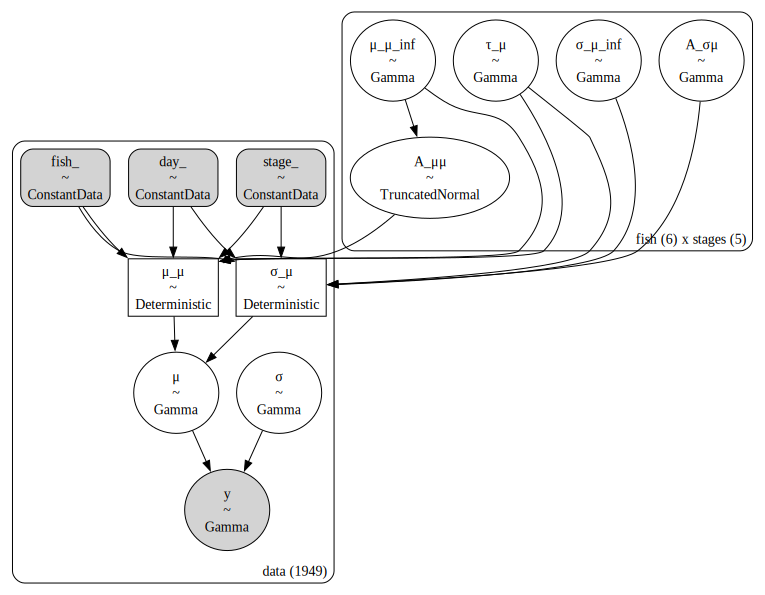

In [11]:
pm.model_to_graphviz(m4_dis)

# Priors
## Sample prior predictive

In [12]:
id_yds = pm.sample_prior_predictive(samples=200, model=m4_dis)
prior = id_yds.prior
pp = id_yds.prior_predictive
cd = id_yds.constant_data

Sampling: [A_μμ, A_σμ, y, μ, μ_μ_inf, σ, σ_μ_inf, τ_μ]


In [13]:
id_yds

Inference data with groups:
	> prior
	> prior_predictive
	> observed_data
	> constant_data

In [14]:
start_day = -25
last_day = start_day

day_ranges = {}
for stage in stage_list:
    day_ranges[stage] = np.arange(last_day, last_day+days[stage])
    last_day = np.max(day_ranges[stage])+1

In [15]:
def plot_hyperparameter_time_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 20)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(prior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            prior_fs = prior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = prior_fs[A_param]
            inf_fs = prior_fs[inf_param]
            τ_fs = prior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index] # Get the specific subplot
            ax.plot(day_ranges[stage_id], param_vals.values.T, alpha=0.4, label=f"{stage_id}")
            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Prior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_16288\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


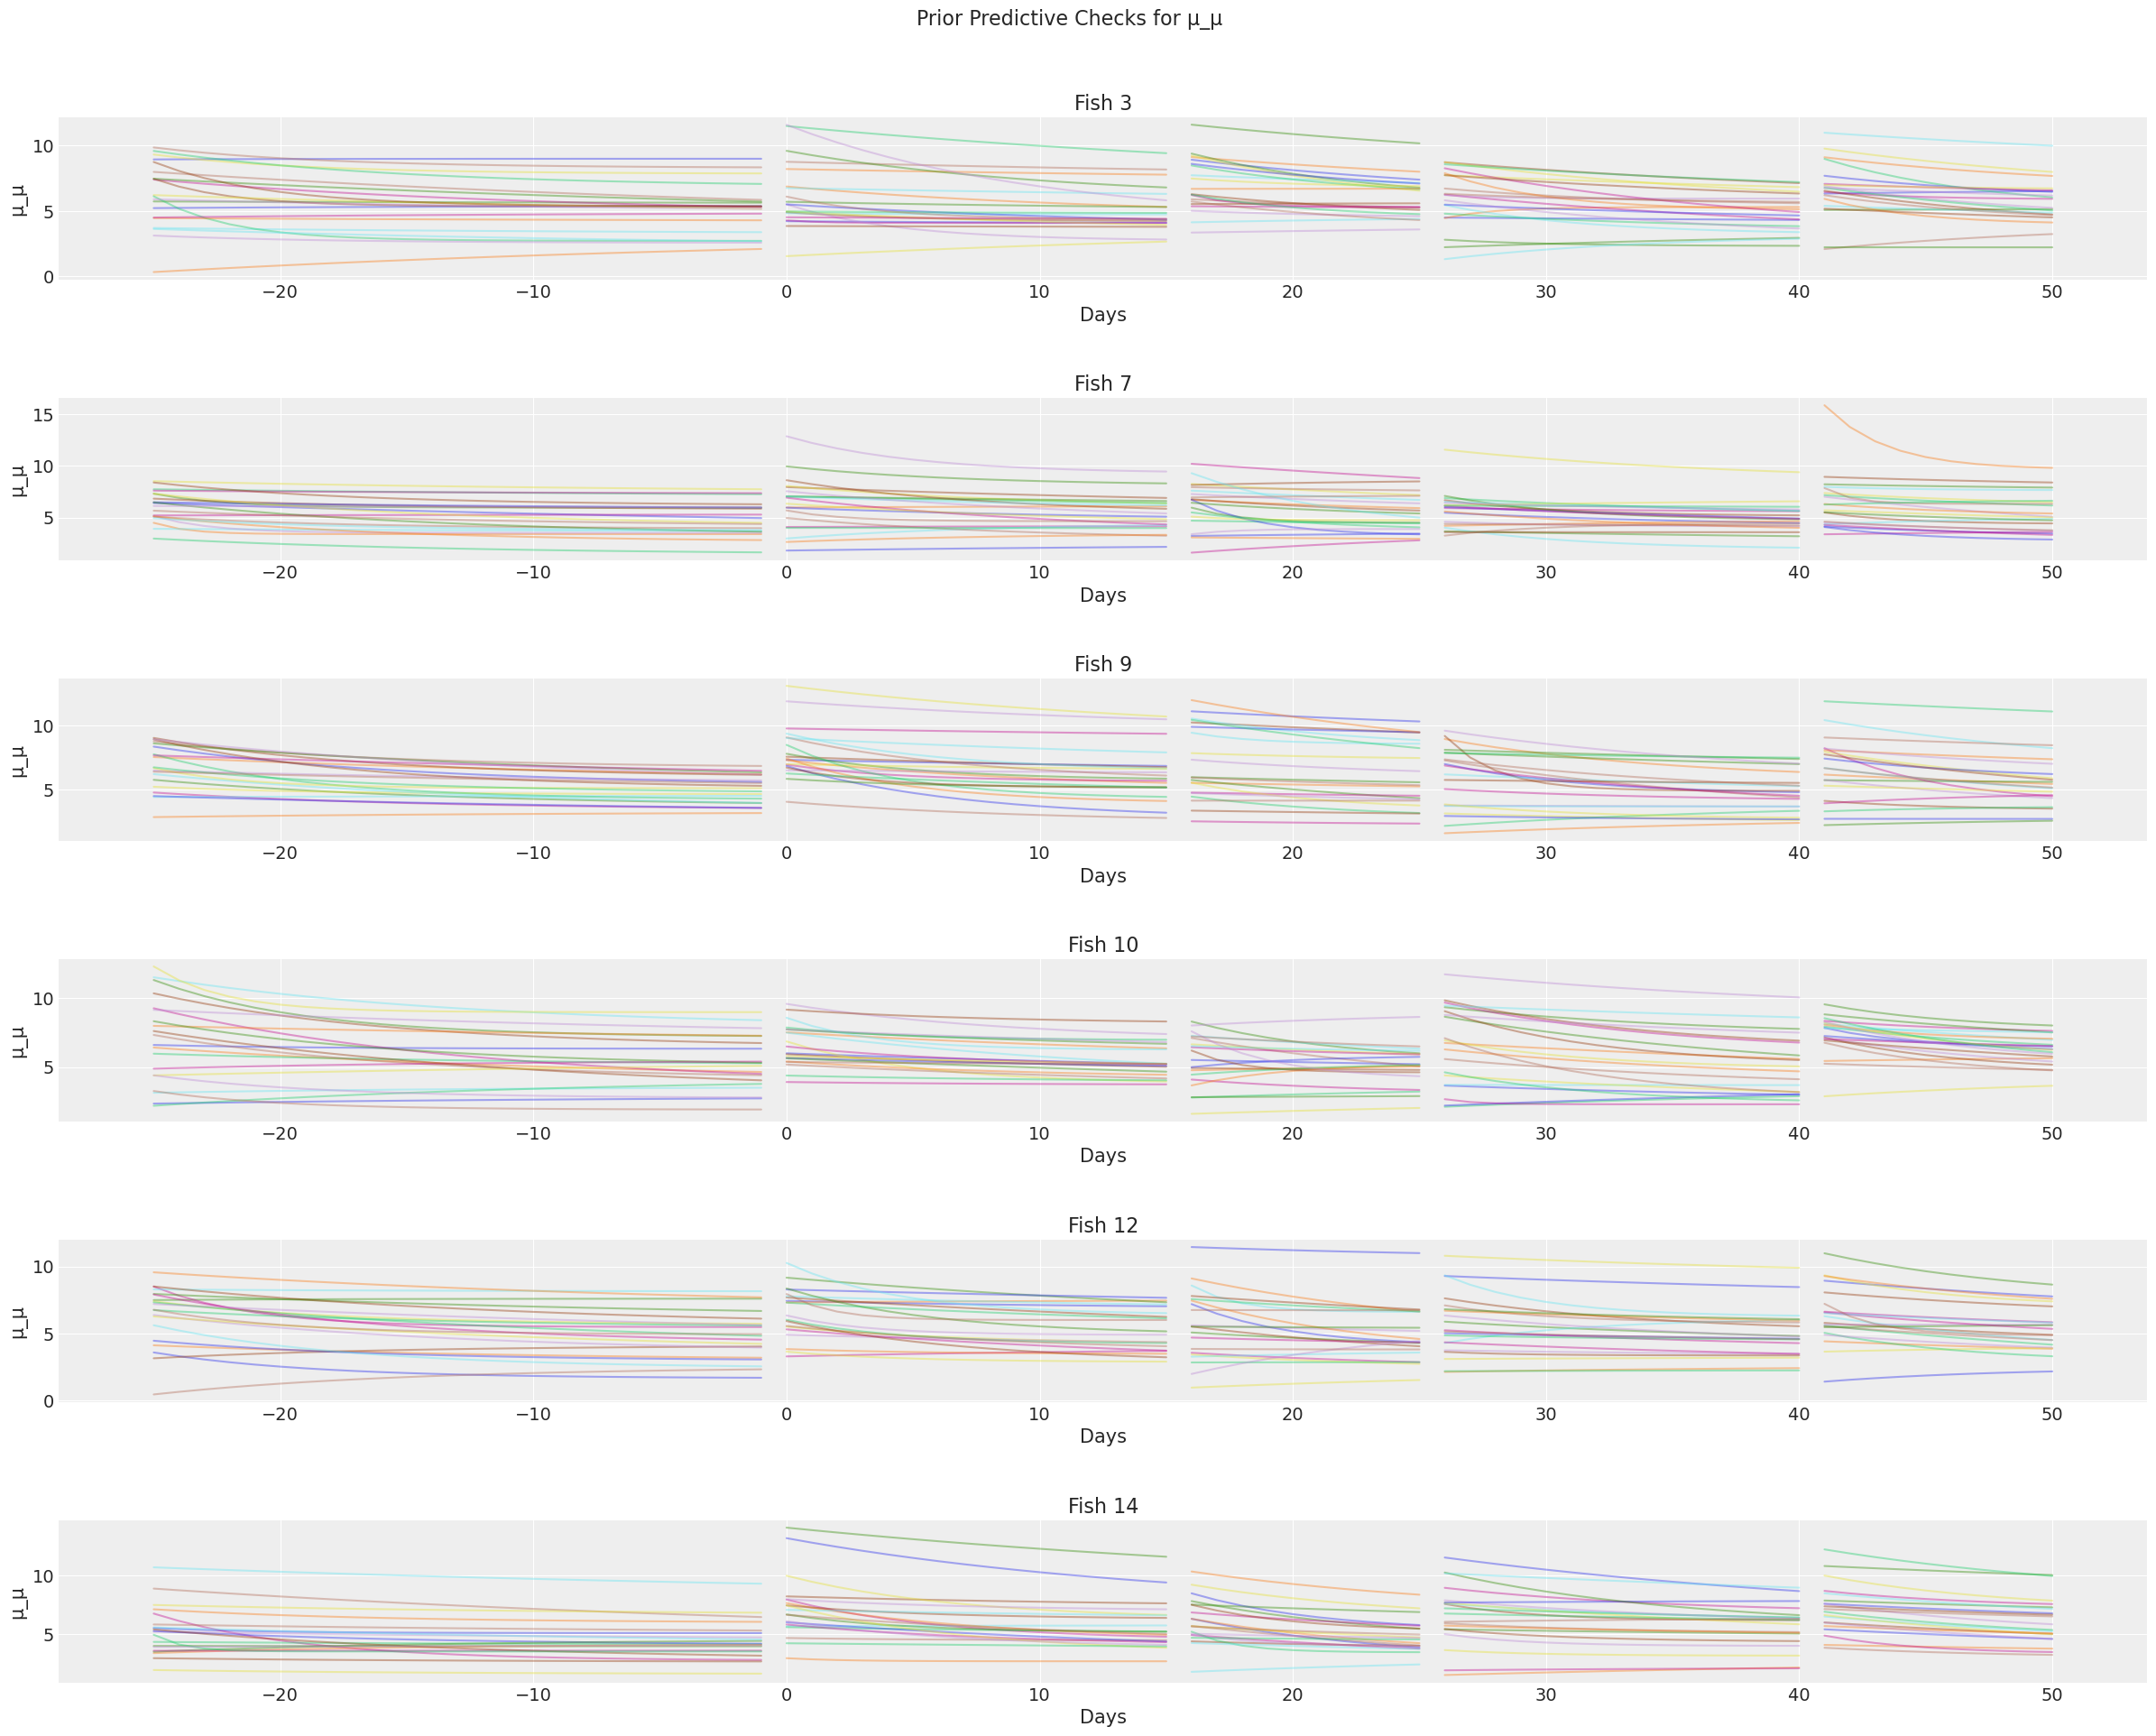

In [16]:
plot_hyperparameter_time_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_16288\4181599608.py:24: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


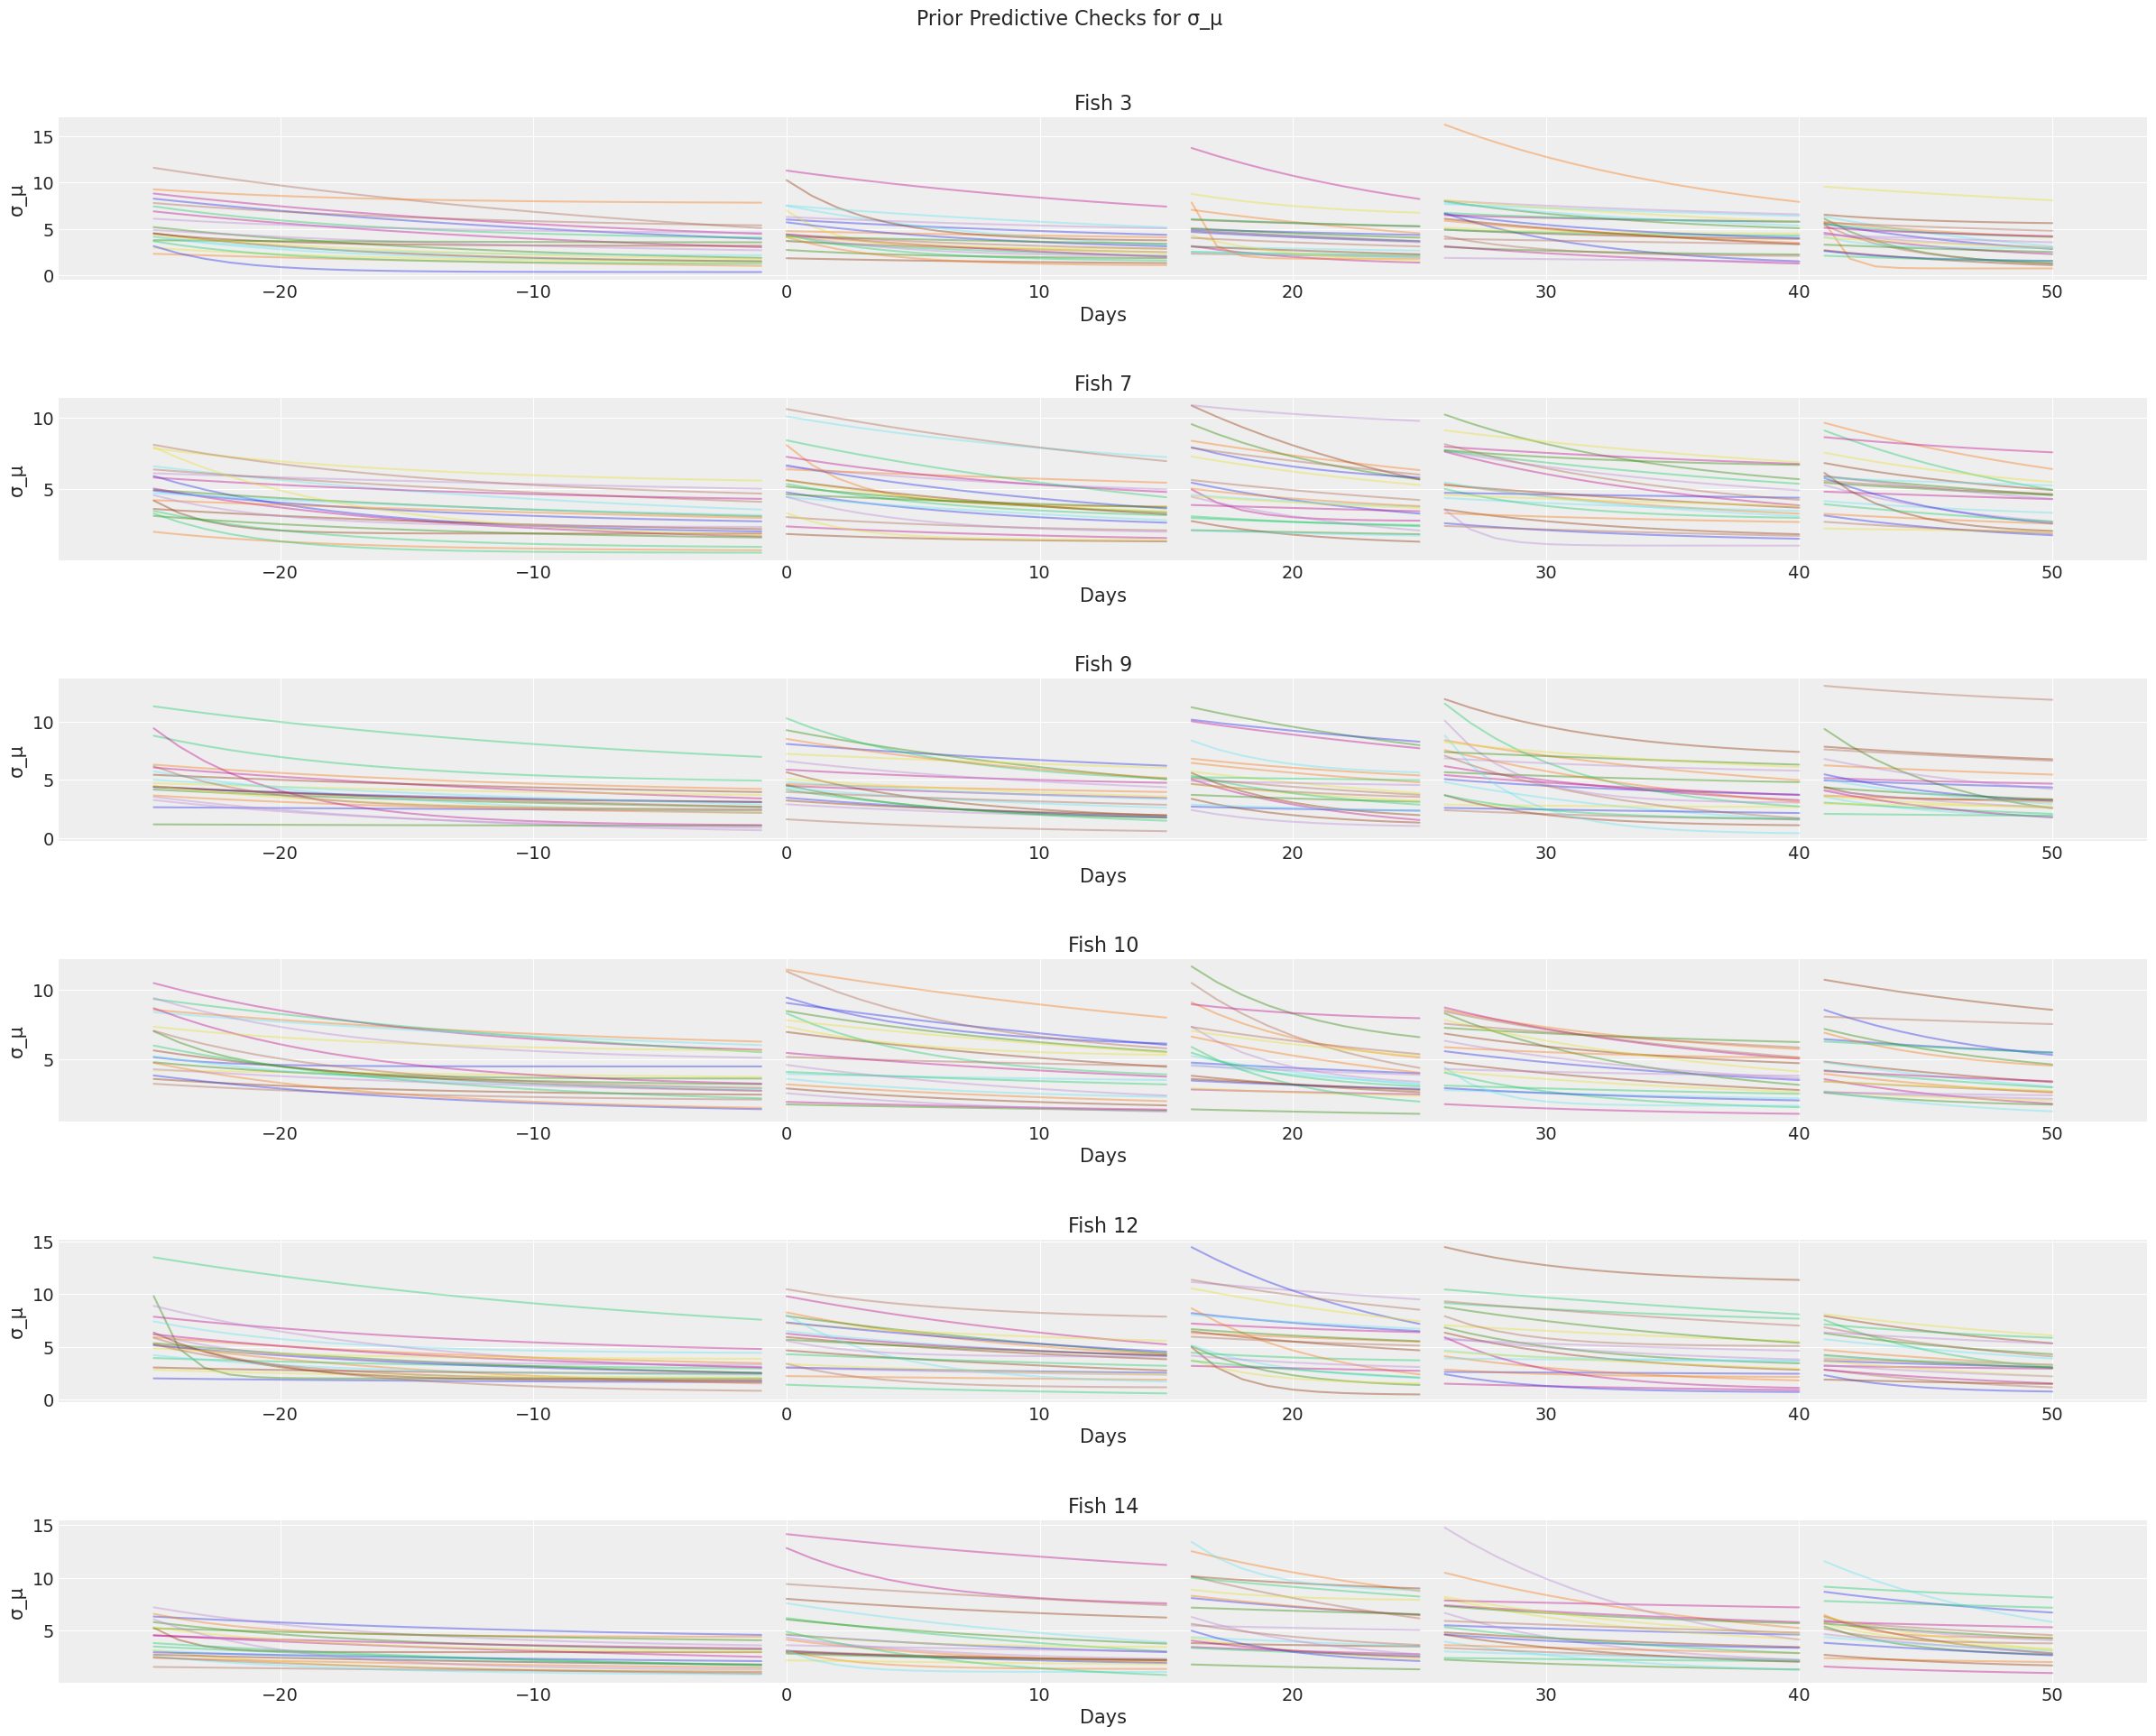

In [17]:
plot_hyperparameter_time_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [18]:
index_stage_map = {v: k for k, v in stage_index_map.items()}
day_range_ = xr.ones_like(cd.day_)
for i in day_range_['data']:
    stage_id = index_stage_map[cd.stage_[i].item()]
    day_range_[i] = day_ranges[stage_id][cd.day_[i].item()-1]


In [19]:
def plot_data_time_course_across_fish(day, data, data_name):
    plot_ds = xr.Dataset(data_vars={'day': day, 'data': data})

    fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

    plot_df = plot_ds.to_dataframe().reset_index()
    plot_df['day'] = plot_df['day'].astype(int)
    sns.violinplot(data=plot_df, x='day', y='data', ax=ax, inner='quartile')
    ax.set_title(f'{data_name}')
    ax.set_xlabel('Days')
    ax.set_ylabel(f'{data_name}')

Text(0, 0.5, 'sigma_yds')

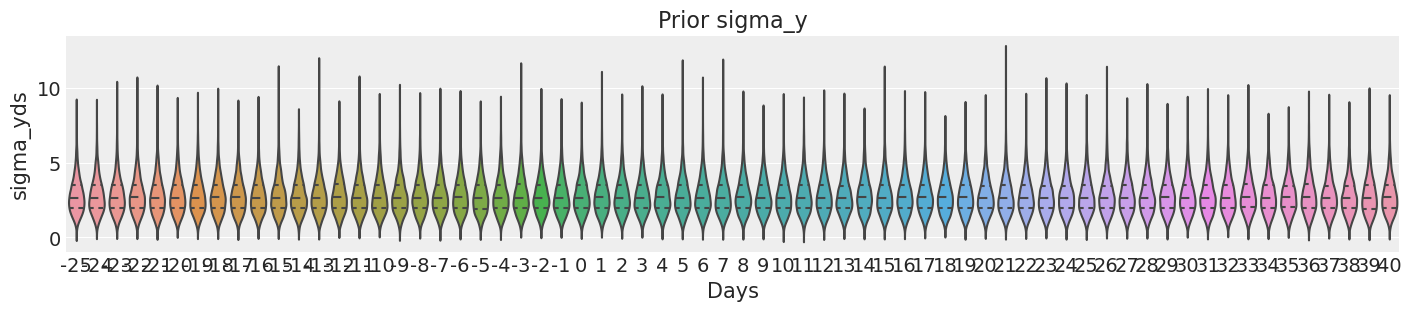

In [20]:
plot_ds = xr.Dataset(data_vars={'day': day_range_, 'fish': cd.fish_, 'sigma_y': prior['σ']})

fig, ax = plt.subplots(1, 1, figsize=(14, 3)) # Adjust the size as needed

plot_df = plot_ds.to_dataframe().reset_index()
plot_df['day'] = plot_df['day'].astype(int)
sns.violinplot(data=plot_df, x='day', y='sigma_y', ax=ax, inner='quartile')
ax.set_title(f'Prior sigma_y')
ax.set_xlabel('Days')
ax.set_ylabel('sigma_yds')

## NumPyro JAX NUTS sampler

In [21]:
with m4_dis:
    id_yds_numpyro = pm.sample(1000, tune=1000, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [τ_μ, μ_μ_inf, A_μμ, A_σμ, σ_μ_inf, μ, σ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 488 seconds.
There were 103 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [22]:
az.summary(id_yds_numpyro, var_names=['A_μμ'], coords={'stages': ['Rotation']})

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
A_μμ[3, Rotation]   1.651  0.987  -0.229    3.421      0.043    0.030   
A_μμ[7, Rotation]   2.209  0.934   0.499    4.051      0.035    0.025   
A_μμ[9, Rotation]   2.677  1.066   0.697    4.722      0.031    0.022   
A_μμ[10, Rotation]  2.112  1.110   0.043    4.157      0.061    0.056   
A_μμ[12, Rotation] -0.508  1.000  -2.315    1.429      0.036    0.026   
A_μμ[14, Rotation] -0.068  0.914  -1.775    1.685      0.041    0.029   

                    ess_bulk  ess_tail  r_hat  
A_μμ[3, Rotation]      536.0    1241.0   1.01  
A_μμ[7, Rotation]      719.0    1244.0   1.01  
A_μμ[9, Rotation]     1175.0    2098.0   1.00  
A_μμ[10, Rotation]     319.0     602.0   1.02  
A_μμ[12, Rotation]     755.0    1508.0   1.01  
A_μμ[14, Rotation]     504.0    1133.0   1.01

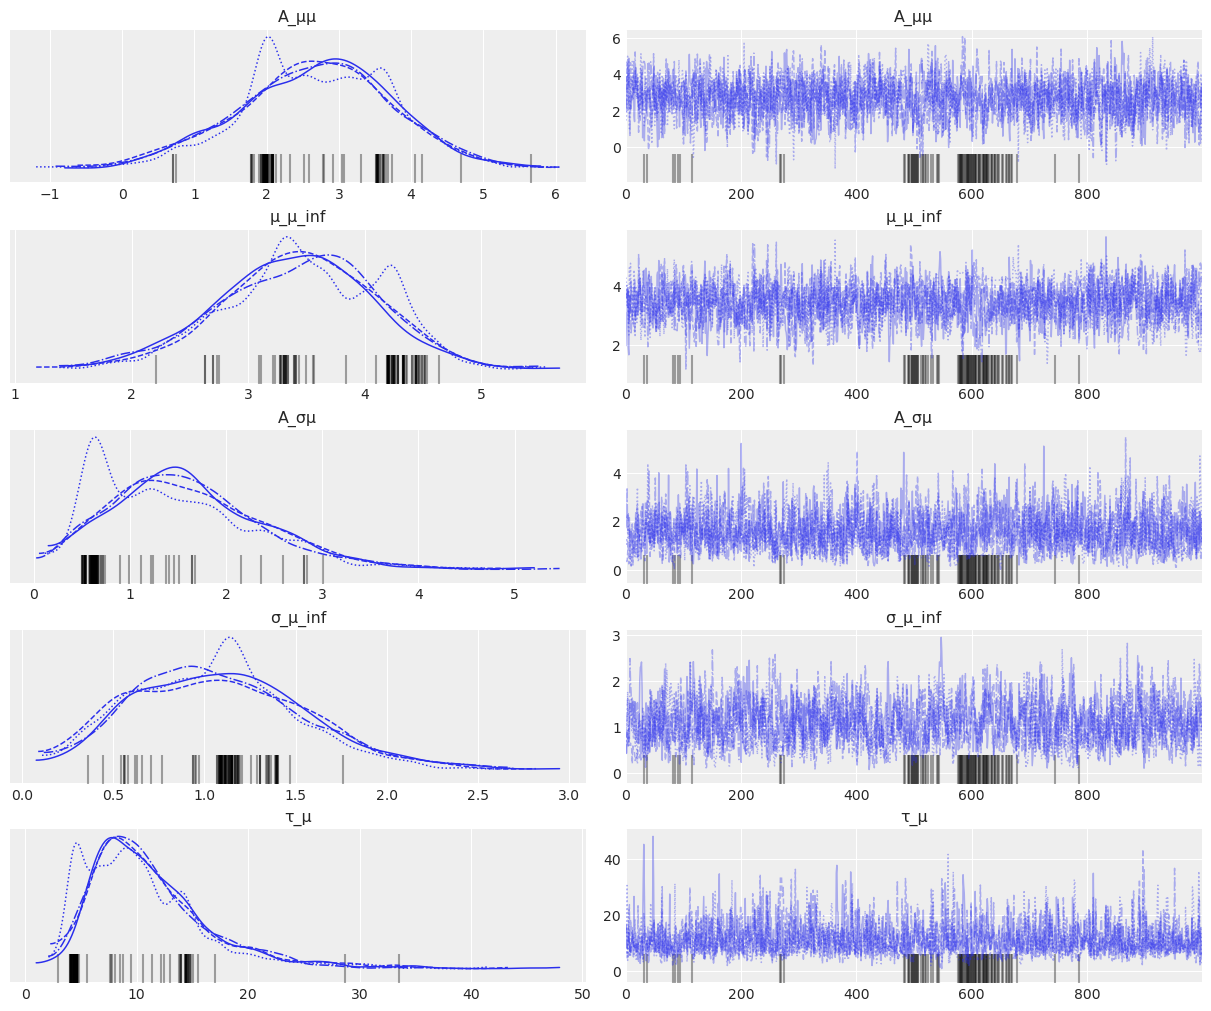

In [23]:
az.plot_trace(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], coords={'fish':9, 'stages': 'Rotation'});

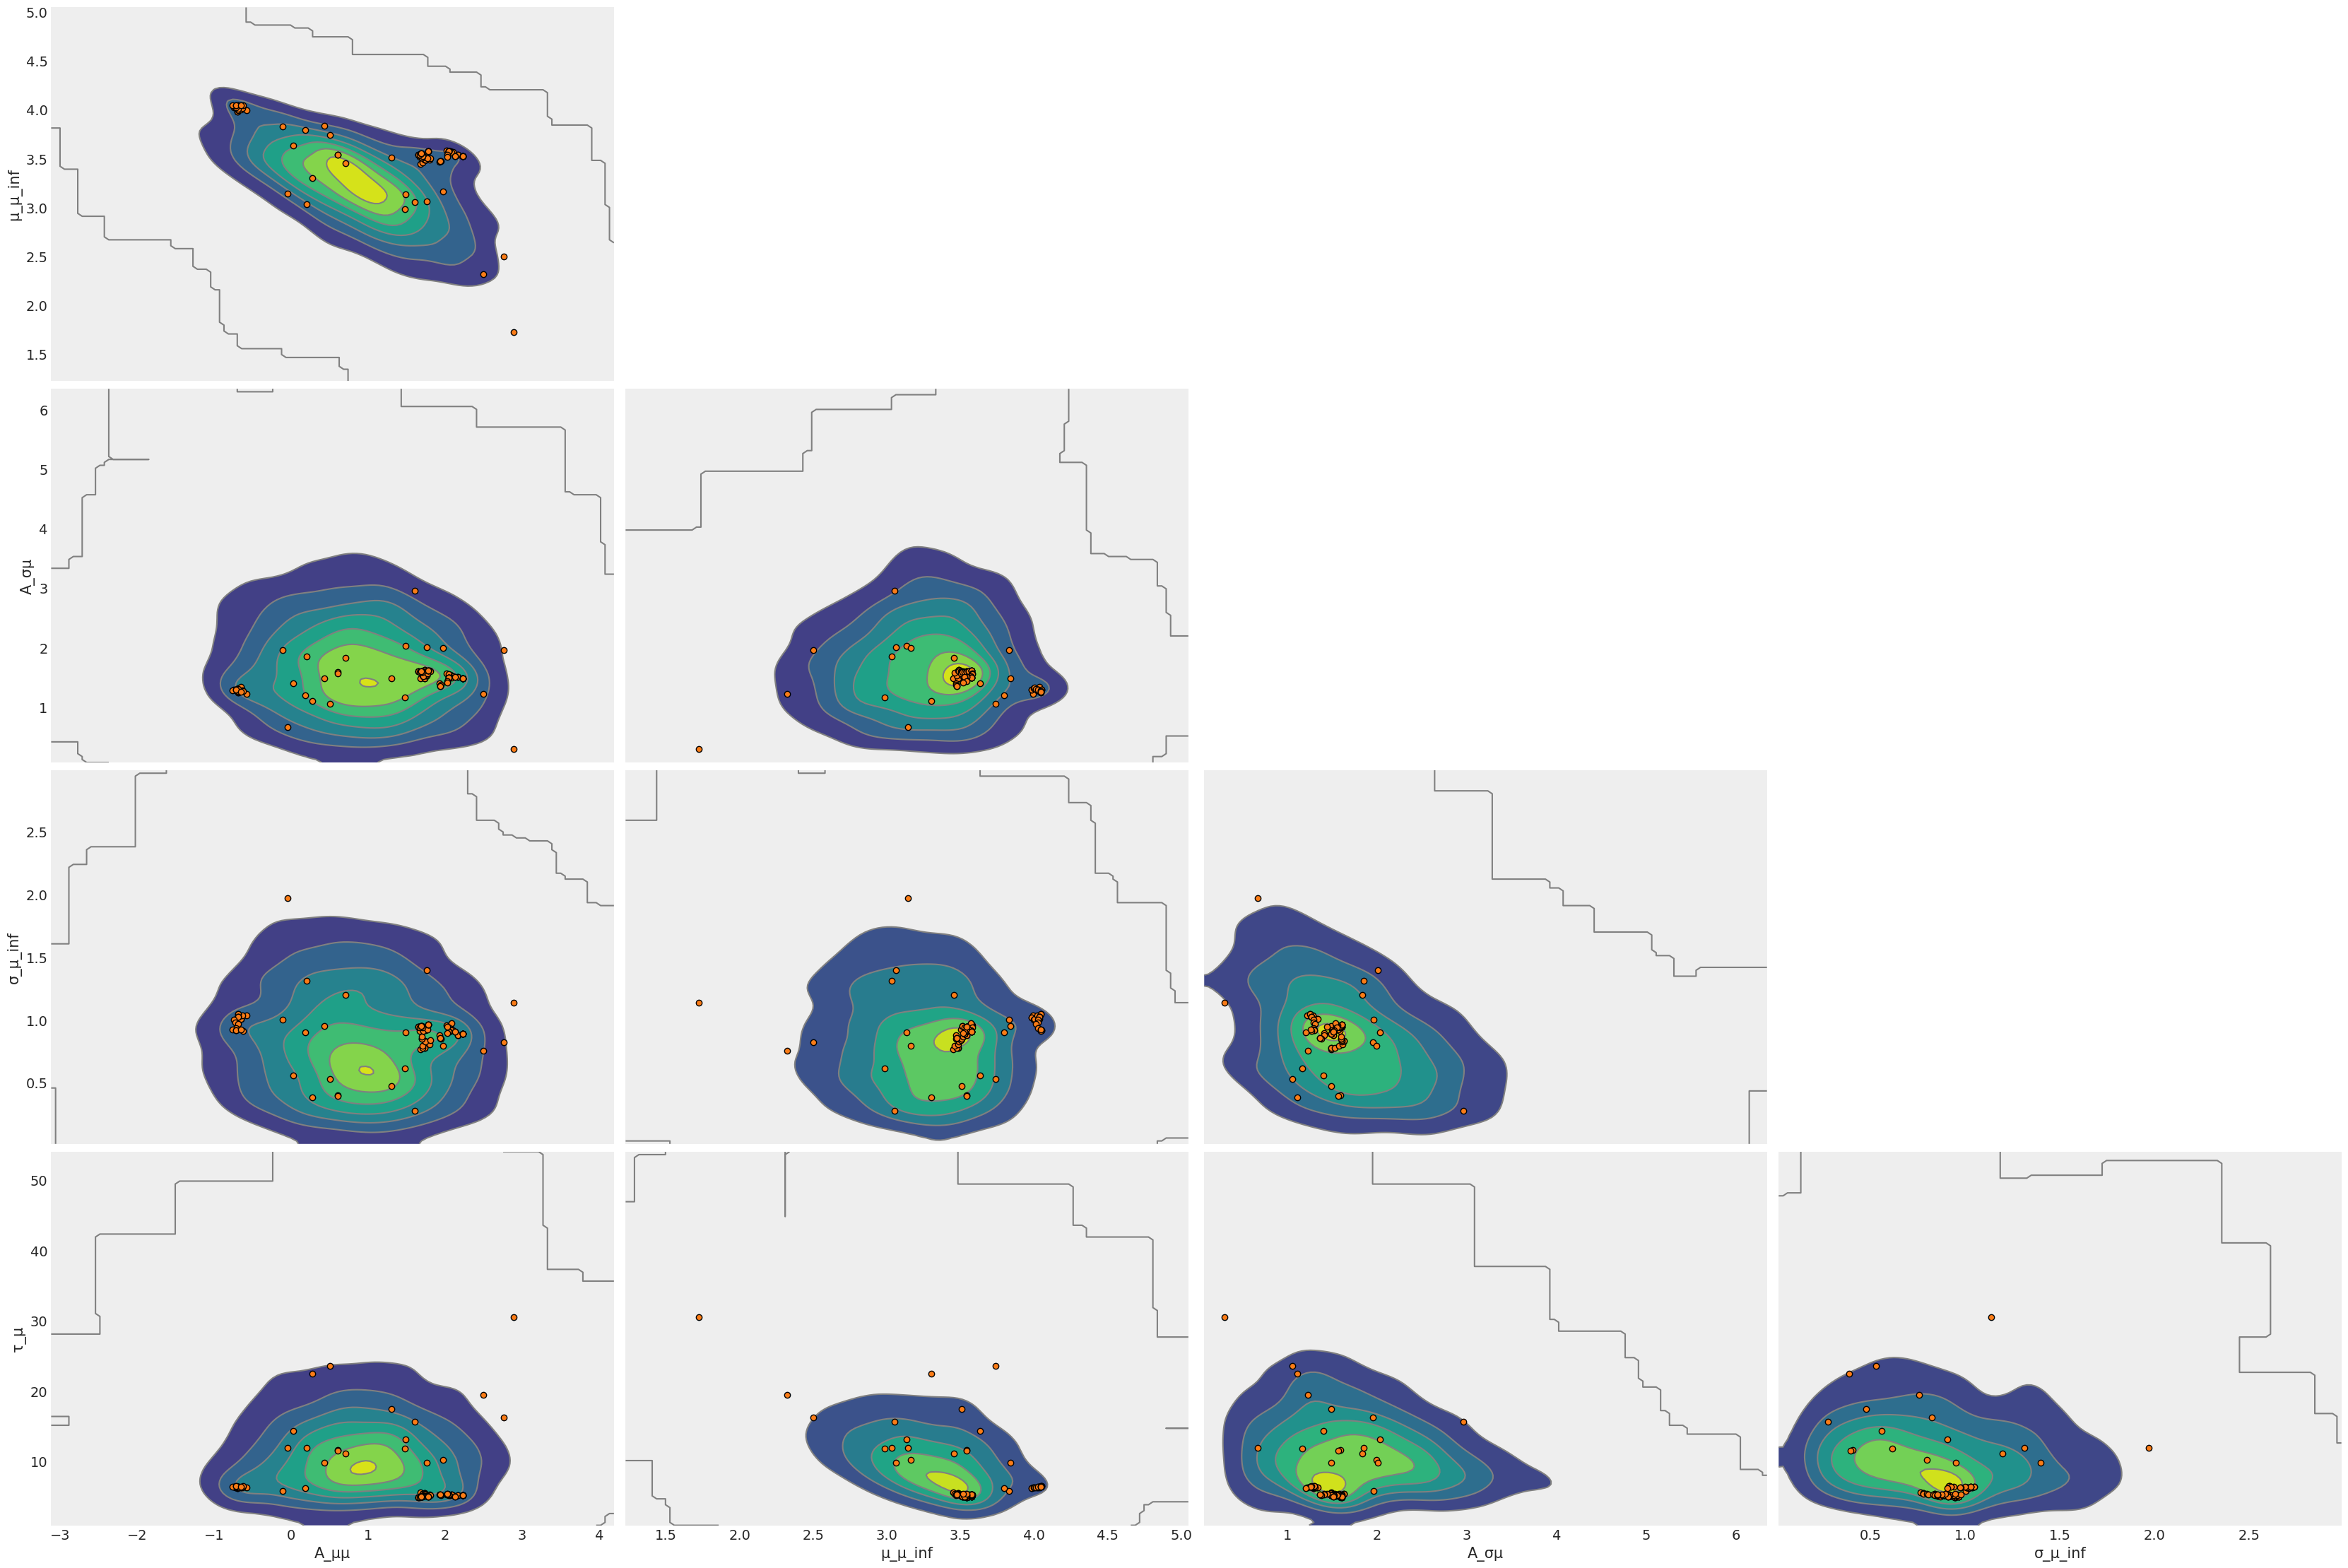

In [24]:
az.plot_pair(id_yds_numpyro, var_names=['A_μμ', 'μ_μ_inf', 'A_σμ', 'σ_μ_inf', 'τ_μ'], 
             coords={'fish':10, 'stages': 'Baseline'}, 
             divergences=True,
             kind='kde');

## Prior preditive plots

In [25]:
with m4_dis:
    pm.sample_posterior_predictive(id_yds_numpyro, extend_inferencedata=True)

Sampling: [y]


In [26]:

posterior = id_yds_numpyro.posterior
ppc = id_yds_numpyro.posterior_predictive
cd = id_yds_numpyro.constant_data
obd = id_yds_numpyro.observed_data


In [27]:
def plot_hyperparameter_ppc_course(A_param, τ_param, inf_param, param_name):
    fig, axes = plt.subplots(len(fish_list), 1, figsize=(25, 10)) # Adjust the size as needed
    num_draws_to_plot = 20

    for fish_id,fish_index in fish_index_map.items():
        draws_f = np.random.choice(posterior.draw.values, size=num_draws_to_plot, replace=False)
        for stage_id,stage_index in stage_index_map.items():
            posterior_fs = posterior.sel({'fish': fish_id, 'stages': stage_id, 'draw': draws_f}).squeeze()
            A_fs = posterior_fs[A_param]
            inf_fs = posterior_fs[inf_param]
            τ_fs = posterior_fs[τ_param]
            
            stage_days = xr.DataArray(np.arange(days[stage_id]), dims="days")
            ppc_param_vals = A_fs * np.exp(-stage_days / τ_fs) + inf_fs
            
            ax = axes[fish_index]  # Get the specific subplot
            for draw_idx in range(num_draws_to_plot):
                ax.plot(day_ranges[stage_id], ppc_param_vals.values.T[:, draw_idx, 1], alpha=0.4, label=f"Draw {draw_idx + 1}")

            ax.set_xlabel("Days")
            ax.set_ylabel(param_name)
            ax.set_title(f"Fish {fish_id}")


    fig.suptitle(f'Posterior Predictive Checks for {param_name}', fontsize=16)  # Add a main title here
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.tight_layout(pad=4.0)
    plt.show()

C:\Users\86153\AppData\Local\Temp\ipykernel_16288\1467832152.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


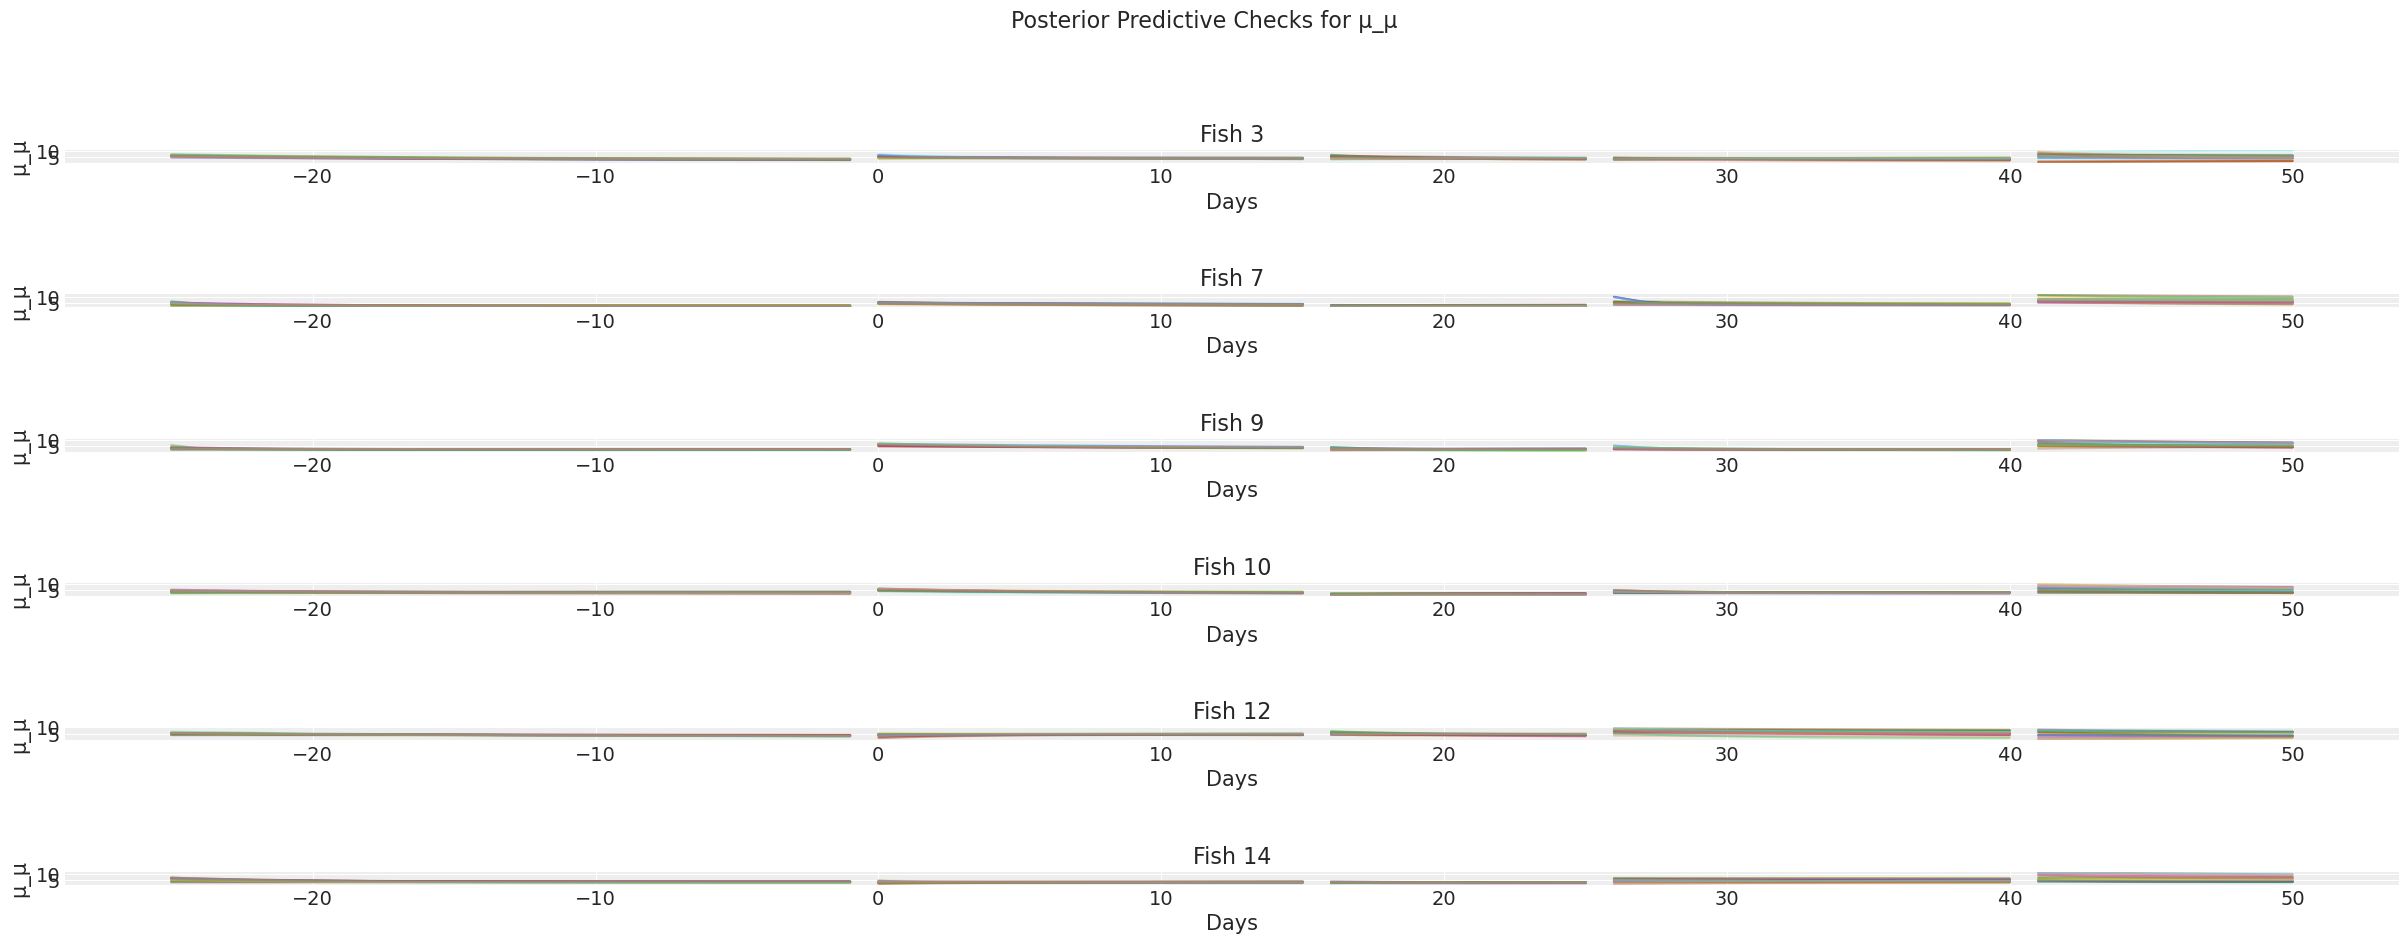

In [28]:
plot_hyperparameter_ppc_course("A_μμ", "τ_μ", "μ_μ_inf", "μ_μ")

C:\Users\86153\AppData\Local\Temp\ipykernel_16288\1467832152.py:26: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title


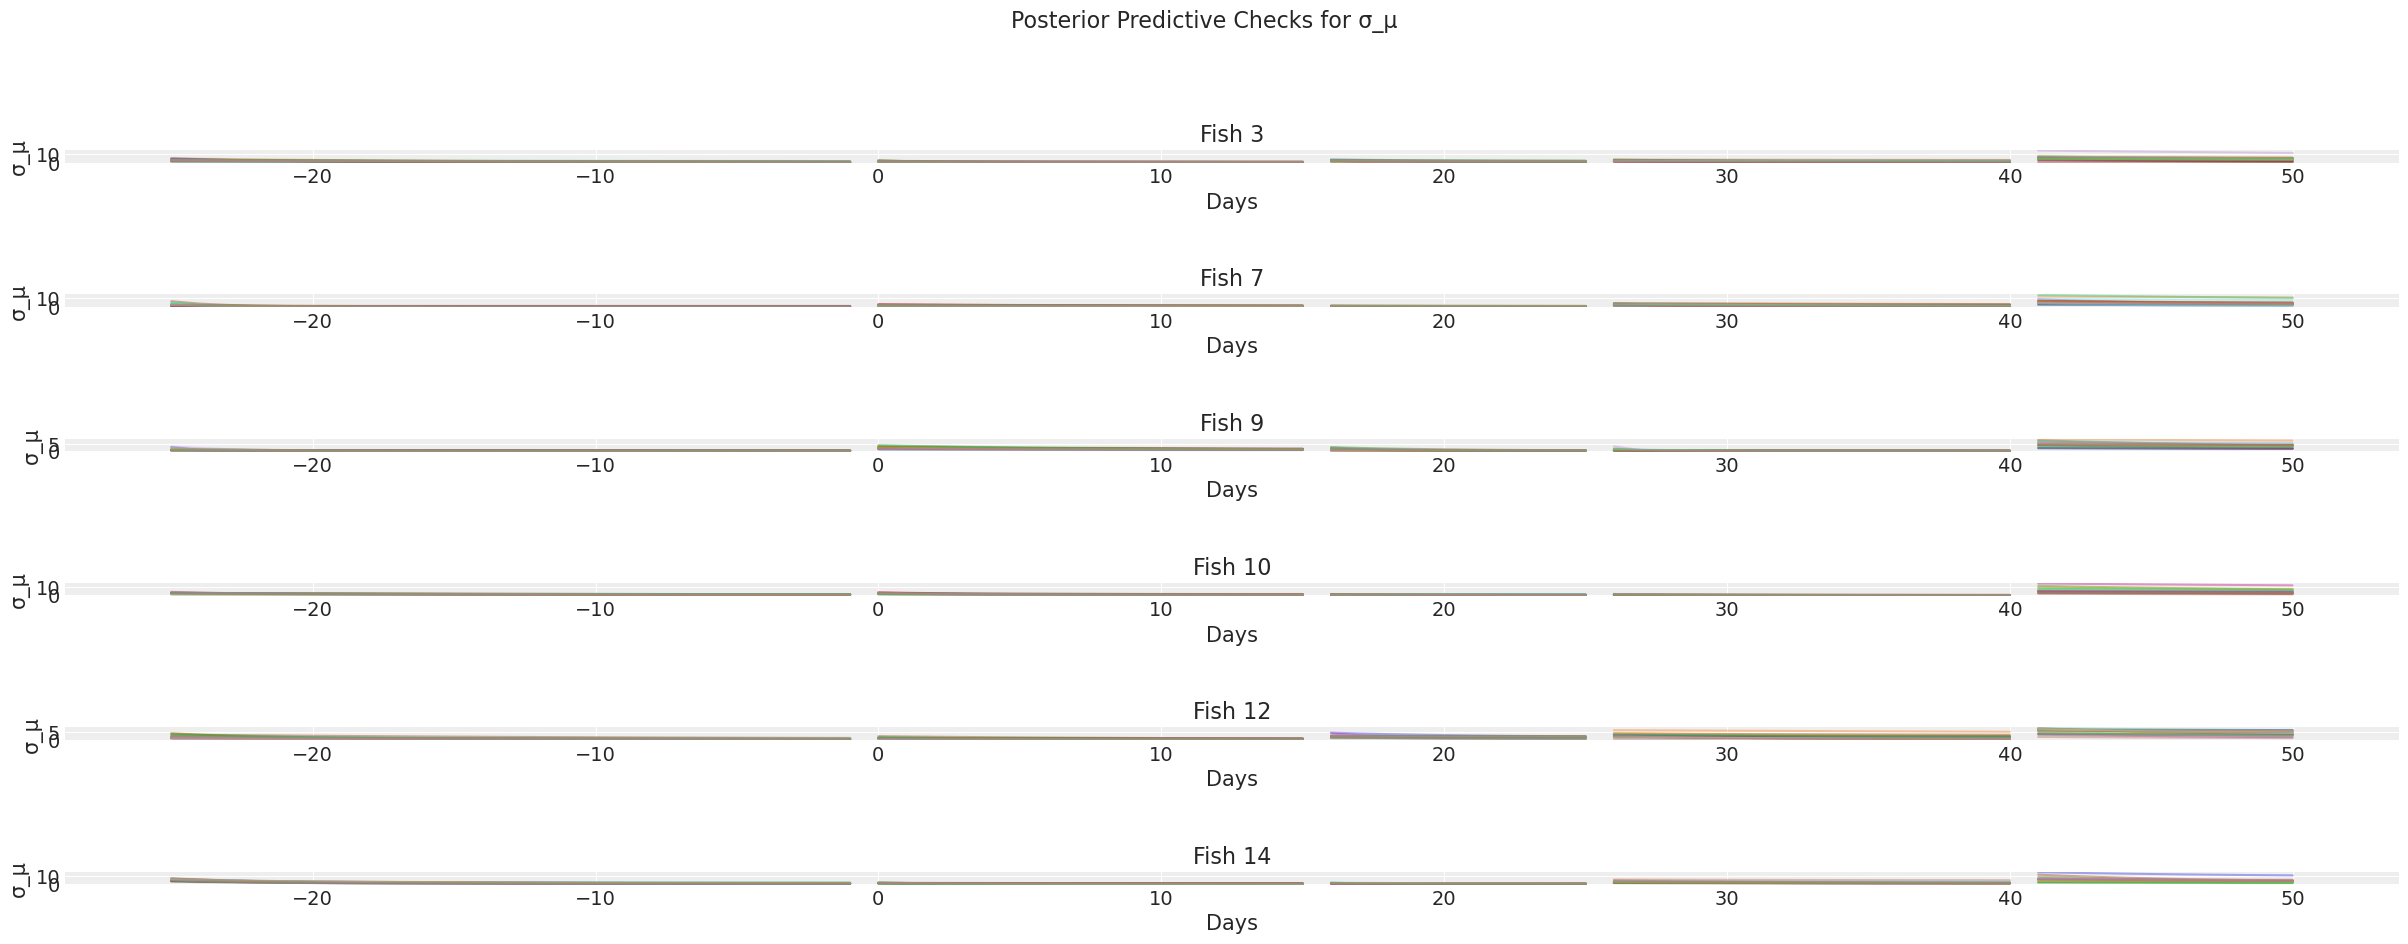

In [29]:
plot_hyperparameter_ppc_course("A_σμ", "τ_μ", "σ_μ_inf", "σ_μ")

In [30]:


# # Define color mapping for trial phases
# phase_colors = {
#     'Baseline': 'yellow',
#     'Rotation': 'red',
#     'Washout': 'green',
#     'ReRotation': 'blue'
# }

# Define the trial phase ranges for each fish
fish_trial_phases = {
    'Fish 3': {
        'Baseline': (1, 155),
        'Rotation': (156, 251),
        'Washout': (252, 311),
        'ReRotation': (312, 359)
    },
    'Fish 7': {
        'Baseline': (360, 430),
        'Rotation': (431, 520),
        'Washout': (521, 580),
        'ReRotation': (581, 616)
    },
    'Fish 9': {
        'Baseline': (617, 757),
        'Rotation': (758, 852),
        'Washout': (853, 911),
        'ReRotation': (912, 1000)
    },
    'Fish 10': {
        'Baseline': (1001, 1149),
        'Rotation': (1150, 1239),
        'Washout': (1240, 1299),
        'ReRotation': (1300, 1388)
    },
    'Fish 12': {
        'Baseline': (1389, 1537),
        'Rotation': (1538, 1627),
        'Washout': (1628, 1687),
        'ReRotation': (1688, 1693)
    },
    'Fish 14': {
        'Baseline': (1694, 1794),
        'Rotation': (1795, 1884),
        'Washout': (1885, 1944),
        'ReRotation': (1945, 1950)
    }


}

# # Plotting side-by-side for each fish and trial phase
# fig, axes = plt.subplots(nrows=len(fish_trial_phases), ncols=1, figsize=(12, 8 * len(fish_trial_phases)))

# for i, (fish_name, trial_phases) in enumerate(fish_trial_phases.items()):
#     ax = axes[i]
    
#     for phase_name, (start_idx, end_idx) in trial_phases.items():
#         # Plot posterior predictive data for the current trial phase with the same color
#         draw_idx = 0  # Choose a specific draw index to plot (adjust as needed)
#         num_draws_to_plot = 100
#         for draw_idx in range(num_draws_to_plot):
#             ax.scatter(range(start_idx, end_idx + 1), ppc.y[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior Predictive (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.1)
            
#             ax.scatter(range(start_idx, end_idx + 1), posterior.μ_μ[1, draw_idx, start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} Posterior μ_μ (Draw {draw_idx + 1})', 
#                 color=phase_colors[phase_name], alpha=0.5)
#             # Plot observed data for the current trial phase with specified color
#         #ax.plot(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#               #  label=f'{fish_name} - {phase_name} (Observed)', color=phase_colors[phase_name])
#         ax.scatter(range(start_idx, end_idx + 1), obd.y[start_idx - 1:end_idx], 
#                 label=f'{fish_name} - {phase_name} (Observed)', color = 'black' )
        
#     ax.set_xlabel('Trial')
#     ax.set_ylabel('Yds')
#     ax.set_title(fish_name)
#     # ax.legend()

# plt.tight_layout()
# plt.show()


In [31]:
# Assuming 'posterior.μ_μ' is your xarray DataArray with dimensions [chain, draw, data]
# and that it has 1387 data points (or any other number, but for the sake of divisibility we assume a correct truncation)

# Ensure data points can be grouped into sets of 6
num_trials = posterior.μ_μ.shape[2]
num_days = num_trials // 6  # floor division to ignore any remainder trials that do not complete a day
trials_per_day = 6

# Truncate the last few trials if they don't make up a full day
truncated_data = posterior.μ_μ[:, :, :num_days * 6]

# Assign a new coordinate that groups every 6 trials into one day
truncated_data.coords['day'] = ('data', np.repeat(np.arange(num_days), trials_per_day))

# Group by the new 'day' coordinate and calculate the mean
daily_μ_μ = truncated_data.groupby('day').mean('data')

# daily_μ_μ now has dimensions [chain, draw, day] where 'day' represents the aggregated mean of every 6 trials


In [32]:
def get_fish_and_stage(day_index, fish_trial_phases, trials_per_day=6):
    # Convert day index to 1-based trial index
    trial_index = day_index * trials_per_day + 1
    
    # Iterate through each fish and their phases to find where the trial_index falls
    for fish, phases in fish_trial_phases.items():
        for stage, (start, end) in phases.items():
            if start <= trial_index <= end:
                return fish, stage
    
    return None, None  # Return None if no matching fish or stage is found


In [33]:
# Determine the number of days (based on the 'day' dimension)
num_days = daily_μ_μ.sizes['day']

# Create lists to hold the 'fish' and 'stage' labels for each day
fish_labels = []
stage_labels = []

# Loop over each day index to determine the corresponding fish and stage
for day_index in range(num_days):
    # Get the full fish name and stage name for the current day index
    fish, stage = get_fish_and_stage(day_index, fish_trial_phases)
    
    # Append the full fish and stage names to the labels lists
    fish_labels.append(fish)
    stage_labels.append(stage)

# Convert the lists to numpy arrays
fish_labels = np.array(fish_labels)
stage_labels = np.array(stage_labels)

# Add 'fish' and 'stage' as coordinates to the 'day' dimension
daily_μ_μ.coords['fish'] = ('day', fish_labels)
daily_μ_μ.coords['stage'] = ('day', stage_labels)

# Now 'daily_μ_μ' has additional coordinates 'fish' and 'stage' associated with each day

In [34]:
μ_μ_plot = az.summary(posterior, var_names=['μ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [64]:
σ_μ_plot = az.summary(posterior, var_names=['σ_μ'], hdi_prob=0.94)  # Adjust hdi_prob as needed (e.g., 0.95 for 94% HDI)

In [35]:
y_ppc_plot = az.summary(ppc, var_names=['y'], hdi_prob=0.94)

In [36]:
y_obd_plot = obd.y.to_dataframe(name="y")

In [37]:
μ_plot = az.summary(posterior, var_names=['μ'], hdi_prob=0.94)


In [69]:

# Define fish_trial_phases dictionary
fish_trial_phases = {
    3: {
        'Baseline': (0, 155),
        'Rotation': (156, 251),
        'Washout': (252, 311),
        'ReRotation': (312, 359)
    },
    7: {
        'Baseline': (360, 430),
        'Rotation': (431, 520),
        'Washout': (521, 580),
        'ReRotation': (581, 616)
    },
    9: {
        'Baseline': (617, 757),
        'Rotation': (758, 852),
        'Washout': (853, 911),
        'ReRotation': (912, 1000)
    },
    10: {
        'Baseline': (1001, 1149),
        'Rotation': (1150, 1239),
        'Washout': (1240, 1299),
        'ReRotation': (1300, 1387)
    },
    12: {
        'Baseline': (1389, 1537),
        'Rotation': (1538, 1627),
        'Washout': (1628, 1687),
        'ReRotation': (1688, 1693)
    },
    14: {
        'Baseline': (1694, 1794),
        'Rotation': (1795, 1884),
        'Washout': (1885, 1944),
        'ReRotation': (1945, 1950)
    }
}

# Function to determine trial phase based on row index
def get_trial_phase(index):
    for fish, phases in fish_trial_phases.items():
        for phase, (start, end) in phases.items():
            if start <= index <= end:
                return fish, phase, index - start + 1
    # Return default values (e.g., NaN) if no trial phase is found
    return None, None, None

# Apply function to create new columns 'fish', 'stage', 'day'
y_obd_plot['index'] = y_obd_plot.index  # Create a new column 'index' to work with the index
y_obd_plot['fish'], y_obd_plot['stage'], y_obd_plot['day'] = zip(*y_obd_plot['index'].map(get_trial_phase))

# Drop the 'index' column (optional)
y_obd_plot.drop(columns=['index'], inplace=True)




In [70]:
# Map day values such that each 6-day cycle is treated as 1 day
y_obd_plot['day'] = np.ceil(y_obd_plot['day'] / 6)

In [71]:


y_obd_plot['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
y_obd_plot['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

# Initialize plotday column with NaN
y_obd_plot['plotday'] = None
# Drop the 'index' column (optional)
# Iterate through each row to calculate plotday based on 'fish' and 'day'
current_fish = None
current_day = None
current_plotday = 0

for index, row in y_obd_plot.iterrows():
    if row['fish'] != current_fish:
        # New fish encountered, reset plotday to 1
        current_fish = row['fish']
        current_day = row['day']
        current_plotday = 1
    elif row['day'] != current_day:
        # Same fish but different day, increment plotday
        current_day = row['day']
        current_plotday += 1
    
    # Update plotday for the current row
    y_obd_plot.at[index, 'plotday'] = current_plotday

# Convert plotday column to numeric
y_obd_plot['plotday'] = pd.to_numeric(y_obd_plot['plotday'], errors='coerce')





In [72]:
# Rename columns in each DataFrame
μ_μ_plot_renamed = μ_μ_plot.rename(columns={'mean': 'μ_μ_y', 'hdi_3%': 'μ_μ_hdi_3%','hdi_97%': 'μ_μ_hdi_97%'})
σ_μ_plot_renamed = σ_μ_plot.rename(columns={'mean': 'σ_μ_y', 'hdi_3%': 'σ_μ_hdi_3%','hdi_97%': 'σ_μ_hdi_97%'})
μ_plot_renamed = μ_plot.rename(columns={'mean': 'μ_y', 'hdi_3%': 'μ_hdi_3%','hdi_97%': 'μ_hdi_97%'})
y_ppc_plot_renamed = y_ppc_plot.rename(columns={'mean': 'ppc_y', 'hdi_3%': 'ppc_hdi_3%','hdi_97%': 'ppc_hdi_97%'})

In [73]:
μ_μ_plot_renamed = μ_μ_plot_renamed.reset_index(drop=True) 
σ_μ_plot_renamed = σ_μ_plot_renamed.reset_index(drop=True) 
μ_plot_renamed = μ_plot_renamed.reset_index(drop=True) 
y_ppc_plot_renamed = y_ppc_plot_renamed.reset_index(drop=True) 

In [141]:
ppcplot_df = pd.concat([y_obd_plot, μ_μ_plot_renamed[['μ_μ_y','μ_μ_hdi_3%','μ_μ_hdi_97%']], σ_μ_plot_renamed[['σ_μ_y','σ_μ_hdi_3%','σ_μ_hdi_97%']],μ_plot_renamed[['μ_y','μ_hdi_3%','μ_hdi_97%']], y_ppc_plot_renamed[['ppc_y','ppc_hdi_3%','ppc_hdi_97%']]], axis=1)

In [75]:

ppcplot_df['fish'] = pd.to_numeric(y_obd_plot['fish'], errors='coerce')
ppcplot_df['day'] = pd.to_numeric(y_obd_plot['day'], errors='coerce')

In [210]:
# Define a list of stages in the correct order
stages = ['Baseline', 'Rotation', 'Washout', 'ReRotation']


# Define color mapping for trial phases
phase_colors = {
    'Baseline': 'yellow',
    'Rotation': 'red',
    'Washout': 'green',
    'ReRotation': 'blue'
}
# Convert 'stage' column to categorical type with specified order
ppcplot_df['stage'] = pd.Categorical(ppcplot_df['stage'], categories=stages, ordered=True)

# Group by 'fish', 'stage', and 'day' columns, calculate mean of 'y' for each group
ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(
    mean_y=('y', 'mean'),
    median_y=('y', 'median'),
    mean_μ_μ_y=('μ_μ_y', 'mean'),
    median_μ_μ_y=('μ_μ_y', 'median'),
    mean_μ_μ_hdi_3=('μ_μ_hdi_3%', 'mean'),
    median_μ_μ_hdi_3=('μ_μ_hdi_3%', 'median'),
    mean_μ_μ_hdi_97=('μ_μ_hdi_97%', 'mean'),
    median_μ_μ_hdi_97=('μ_μ_hdi_97%', 'median'),
    mean_σ_μ_y=('σ_μ_y', 'mean'),
    median_σ_μ_y=('σ_μ_y', 'median'),
    mean_σ_μ_hdi_3=('σ_μ_hdi_3%', 'mean'),
    median_σ_μ_hdi_3=('σ_μ_hdi_3%', 'median'),
    mean_σ_μ_hdi_97=('σ_μ_hdi_97%', 'mean'),
    median_σ_μ_hdi_97=('σ_μ_hdi_97%', 'median'),
    mean_μ_y=('μ_y', 'mean'),
    median_μ_y=('μ_y', 'median'),
    mean_μ_hdi_3=('μ_hdi_3%', 'mean'),
    median_μ_hdi_3=('μ_hdi_3%', 'median'),
    mean_μ_hdi_97=('μ_hdi_97%', 'mean'),
    median_μ_hdi_97=('μ_hdi_97%', 'median'),
    mean_ppc_y=('ppc_y', 'mean'),
    median_ppc_y=('ppc_y', 'median'),
    mean_ppc_hdi_3=('ppc_hdi_3%', 'mean'),
    median_ppc_hdi_3=('ppc_hdi_3%', 'median'),
    mean_ppc_hdi_97=('ppc_hdi_97%', 'mean'),
    median_ppc_hdi_97=('ppc_hdi_97%', 'median')
).reset_index()

# Define conditions to set 'plotday' to NaN where 'mean_y' is NaN
condition = pd.isna(ppcplot_df_day['mean_y'])

# Set 'plotday' to NaN where 'mean_y' is NaN
ppcplot_df_day.loc[condition, 'plotday'] = None

# Calculate 'plotday' based on change in 'day' within the same 'fish' group where 'mean_y' is not NaN
ppcplot_df_day.loc[~condition, 'plotday'] = (
    ppcplot_df_day.loc[~condition].groupby('fish').cumcount()
    + (ppcplot_df_day.loc[~condition, 'day'] != ppcplot_df_day.loc[~condition, 'day'].shift()).astype(int)
)
ppcplot_df_day = ppcplot_df_day[pd.notna(ppcplot_df_day['mean_y'])]
ppcplot_df_day['plotday'] = pd.to_numeric(ppcplot_df_day['plotday'], errors='coerce')



C:\Users\86153\AppData\Local\Temp\ipykernel_16288\4128348666.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  ppcplot_df_day = ppcplot_df.groupby(['fish', 'stage', 'day']).agg(


In [211]:
def gamma_median(m, s):
    v = s**2
    ra = (m + np.sqrt(m**2 + 4*v)) / (2*v)
    sh = 1+m*ra
    return stats.gamma.ppf(0.5, a=sh, scale=1/ra)

In [212]:
# Compute the median of the gamma distribution
μ_hdi_3_gamma_medians = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['median_μ_μ_hdi_3'],
    ppcplot_df_day['median_σ_μ_hdi_3'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [213]:
# Compute the median of the gamma distribution
μ_hdi_97_gamma_medians = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['median_μ_μ_hdi_97'],
    ppcplot_df_day['median_σ_μ_hdi_97'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [214]:
# Compute the median of the gamma distribution
μ_hdi_3_gamma_means = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['mean_μ_μ_hdi_3'],
    ppcplot_df_day['mean_σ_μ_hdi_3'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]

)
# Compute the median of the gamma distribution
μ_hdi_97_gamma_means = xr.apply_ufunc(
    gamma_median,
    ppcplot_df_day['mean_μ_μ_hdi_97'],
    ppcplot_df_day['mean_σ_μ_hdi_97'],
    input_core_dims=[[], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)

In [215]:
# Initialize an empty list to store the variable names and values
μ_hdi_97_gamma_medians_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_97_gamma_medians.data_vars:
    value = μ_hdi_97_gamma_medians[var].values.item()
    μ_hdi_97_gamma_medians_val.append((value))


In [216]:
# Initialize an empty list to store the variable names and values
μ_hdi_3_gamma_medians_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_3_gamma_medians.data_vars:
    value = μ_hdi_3_gamma_medians[var].values.item()
    μ_hdi_3_gamma_medians_val.append((value))


In [217]:
# Initialize an empty list to store the variable names and values
μ_hdi_97_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_97_gamma_means.data_vars:
    value = μ_hdi_97_gamma_means[var].values.item()
    μ_hdi_97_gamma_means_val.append((value))

    # Initialize an empty list to store the variable names and values
μ_hdi_3_gamma_means_val = []

# Iterate through each data variable in the Dataset
for var in μ_hdi_3_gamma_means.data_vars:
    value = μ_hdi_3_gamma_means[var].values.item()
    μ_hdi_3_gamma_means_val.append((value))

In [218]:
# Create a DataFrame from the lists
median_df = pd.DataFrame({
    'μ_hdi_3_gamma_medians': μ_hdi_3_gamma_medians_val,
    'μ_hdi_97_gamma_medians': μ_hdi_97_gamma_medians_val,

    'μ_hdi_3_gamma_means': μ_hdi_3_gamma_means_val,
    'μ_hdi_97_gamma_means': μ_hdi_97_gamma_means_val,

})

In [219]:
# Reset indices if they are not aligned
ppcplot_df_day = ppcplot_df_day.reset_index(drop=True)
median_df = median_df.reset_index(drop=True)
combined_df = []
combined_df = pd.concat([ppcplot_df_day, median_df], axis=1)
ppcplot_df_day = combined_df


In [220]:
ppcplot_df_day.to_csv('disppcplot.csv',index=False)

In [221]:
y_obd_plot.to_csv('disy_obdplot.csv', index=False)

# Plots

## learning rates of each fish

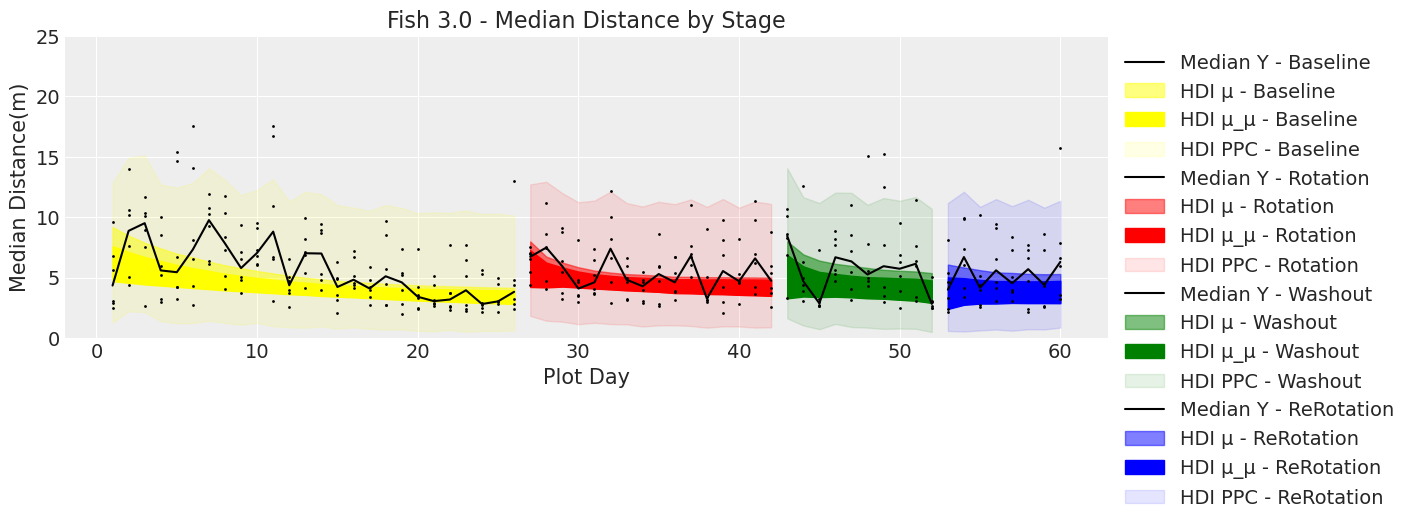

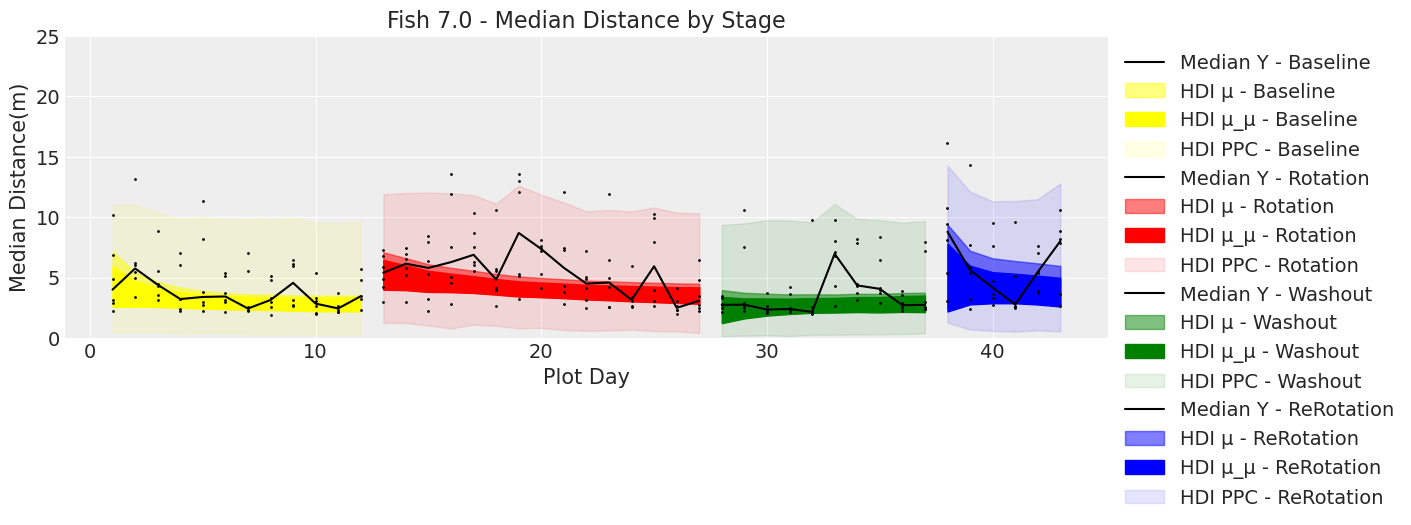

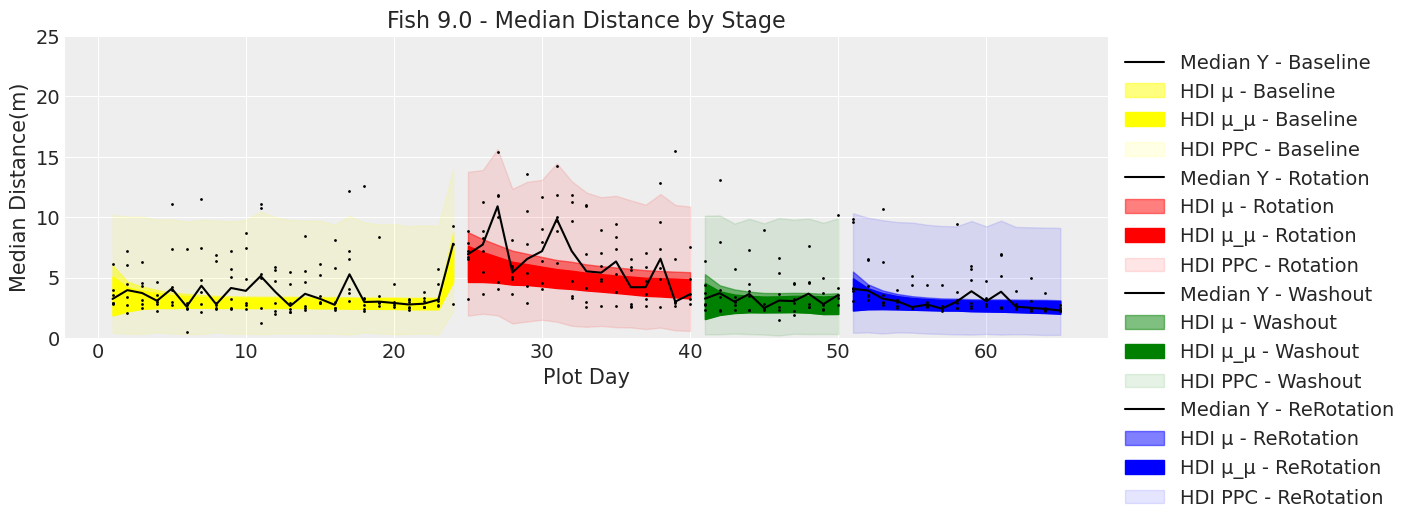

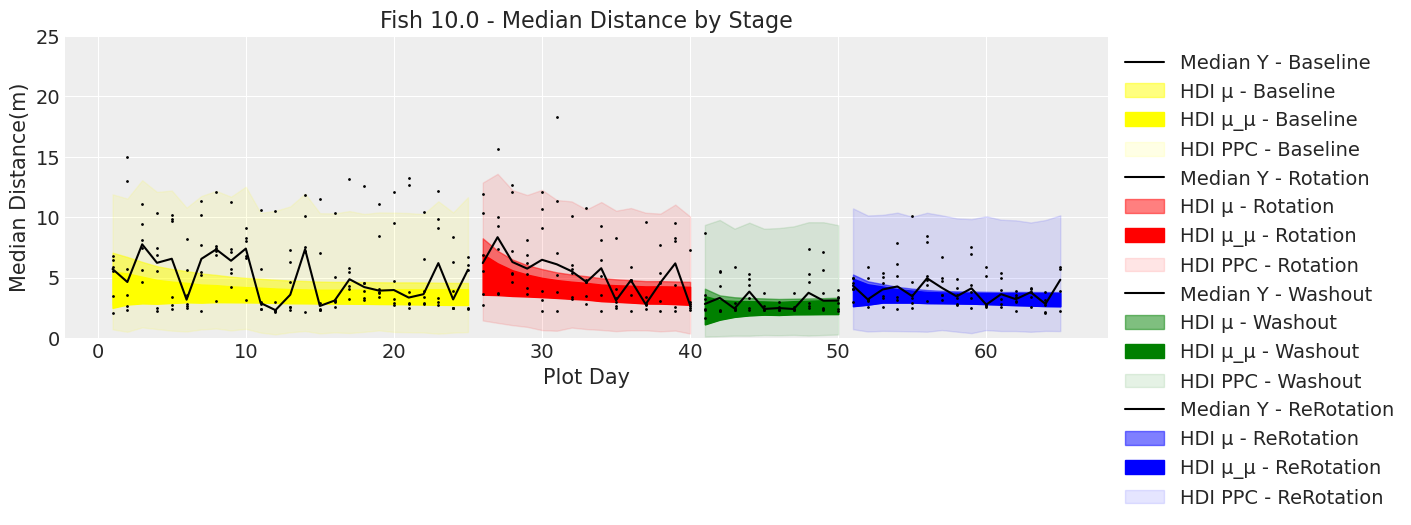

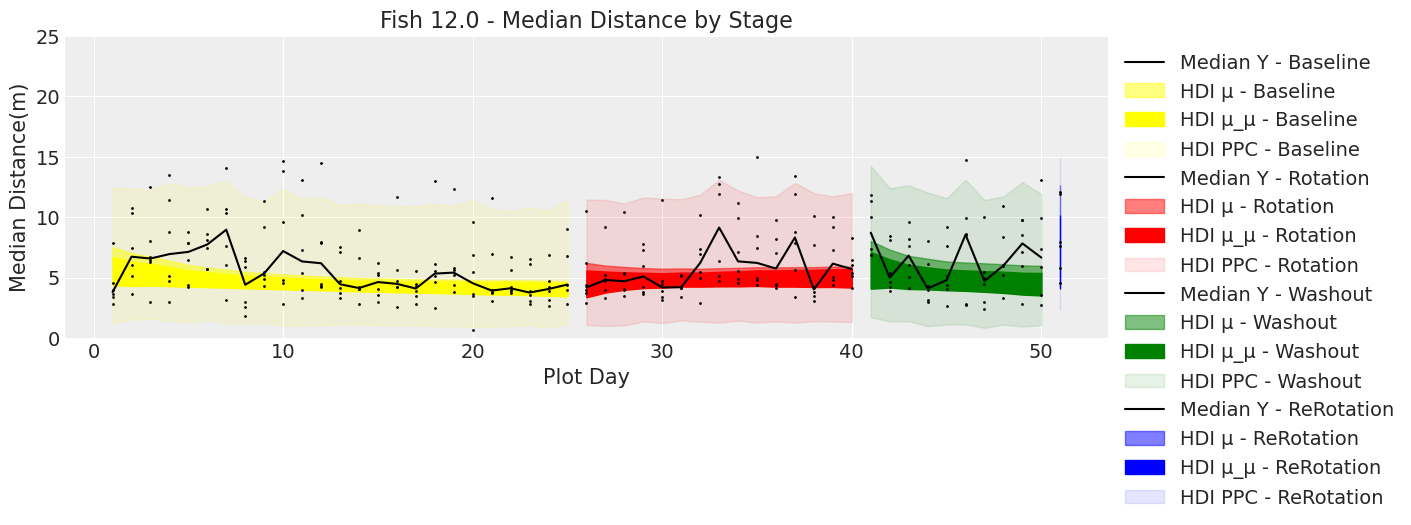

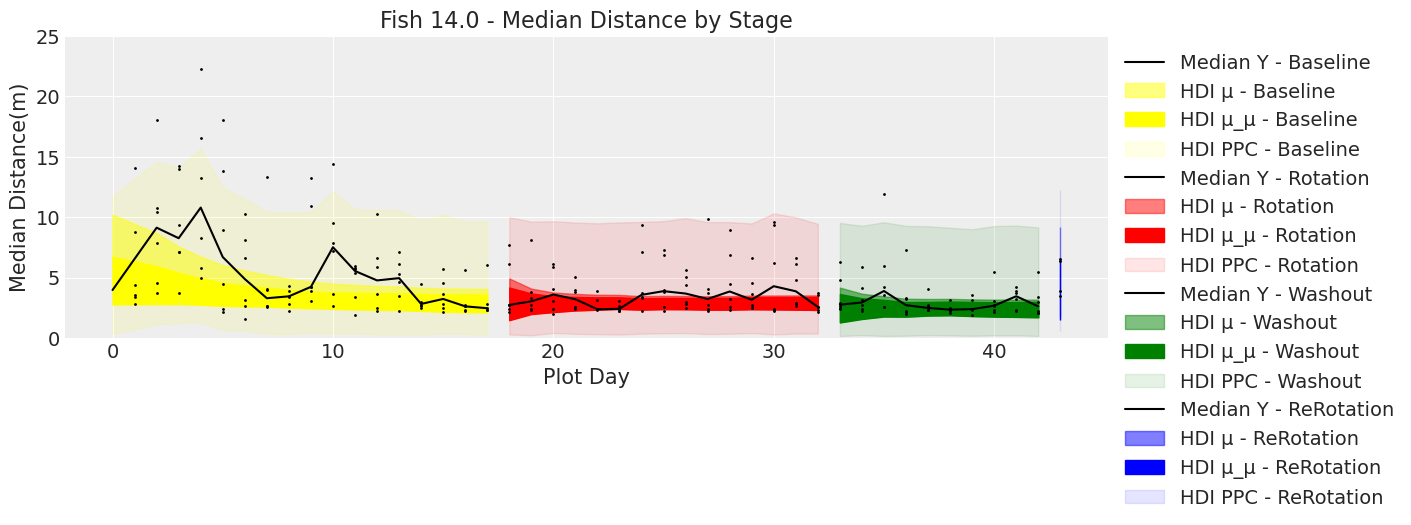

In [222]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(14, 4.8))  # Set figure size
    
    for i, stage in enumerate(stages):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
       # plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
        plt.plot(data_filter['plotday'], data_filter['median_y'], label=f'Median Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_medians'], data_filter['μ_hdi_97_gamma_medians'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
      #  plt.fill_between(data_filter['plotday'], data_filter['median_μ_hdi_3'], data_filter['median_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['median_μ_μ_hdi_3'], data_filter['median_μ_μ_hdi_97'],color=phase_colors[stage], alpha=1, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['median_ppc_hdi_3'], data_filter['median_ppc_hdi_97'],
                            color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color= 'black',s =1)
    
    plt.xlabel('Plot Day')  # Set x-axis label
    plt.ylabel('Median Distance(m)')   # Set y-axis label
    plt.title(f'Fish {fish} - Median Distance by Stage')  # Set plot title
    plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((0,25))
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot


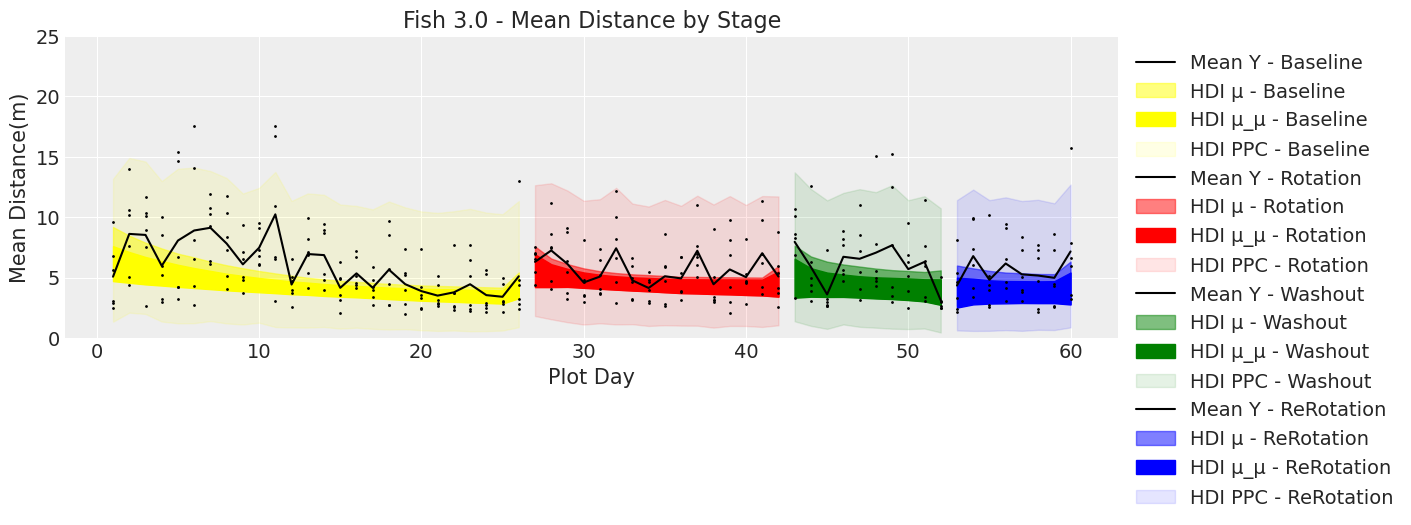

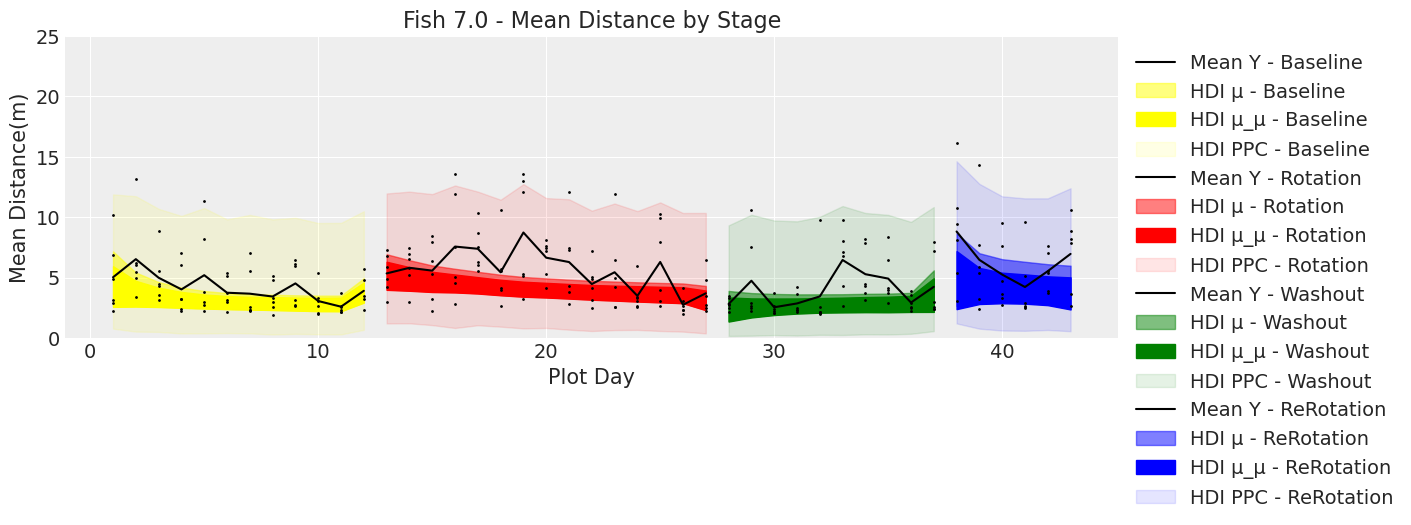

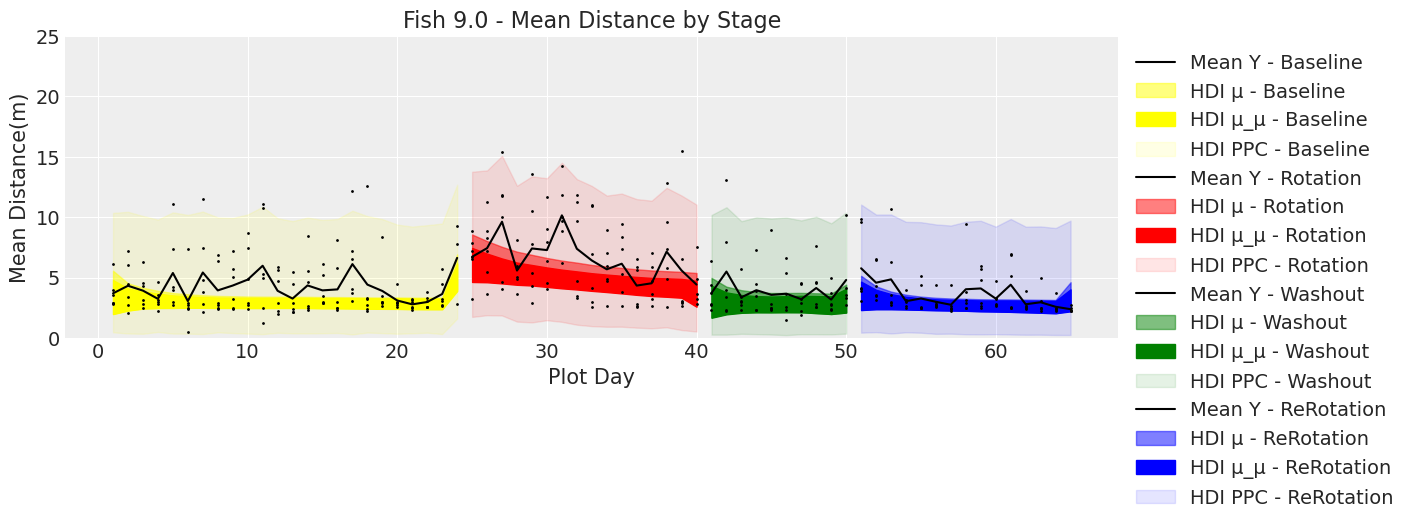

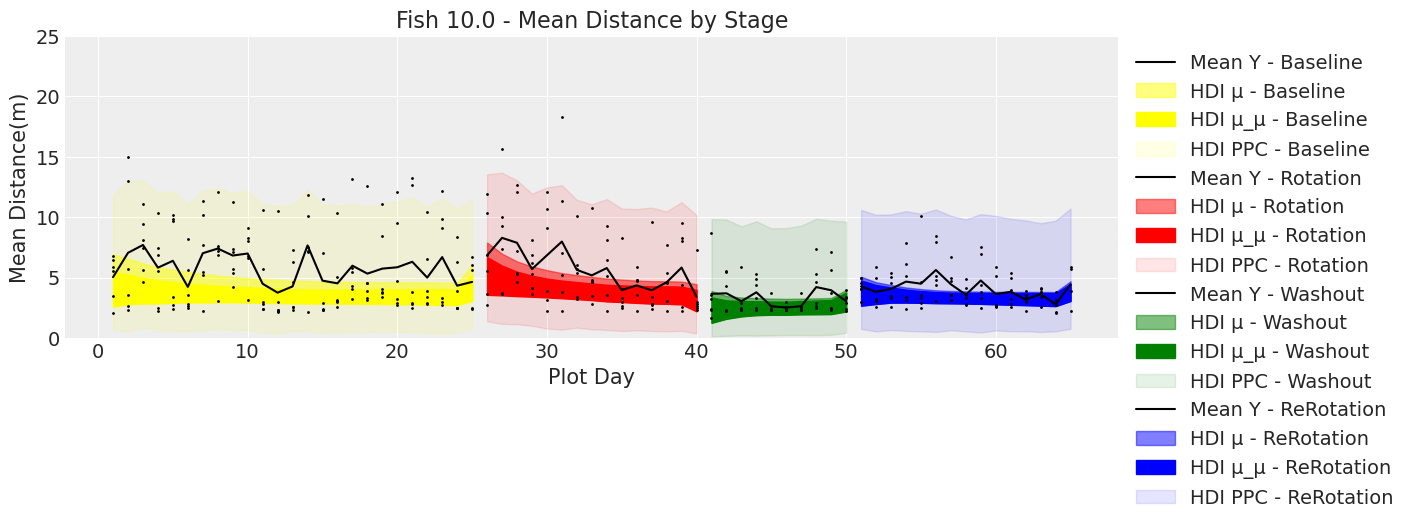

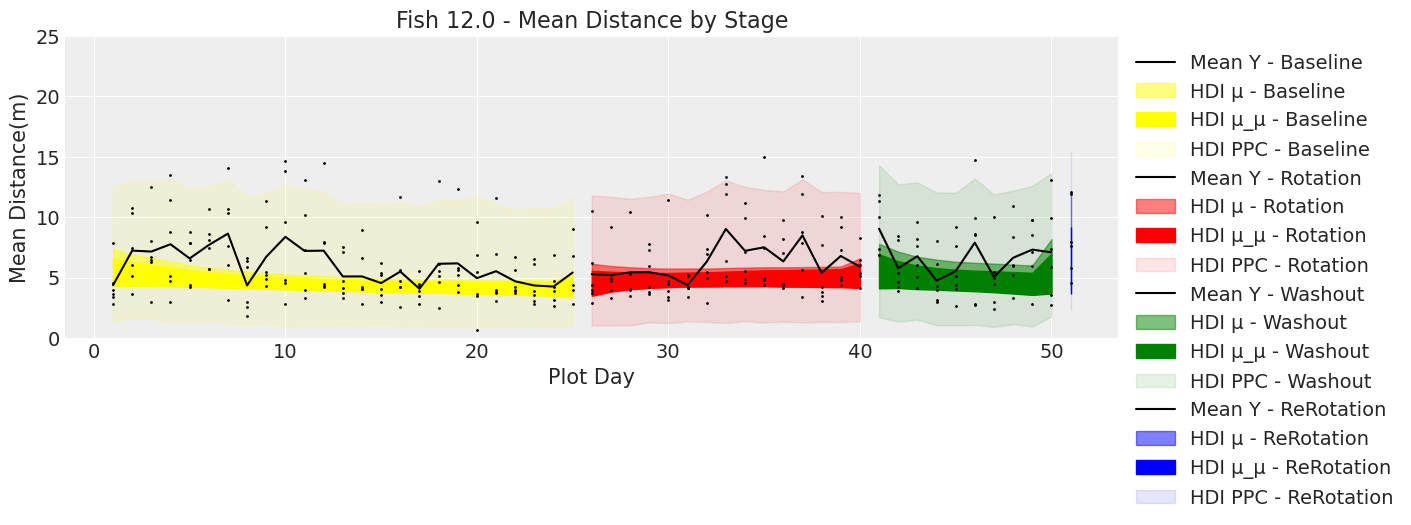

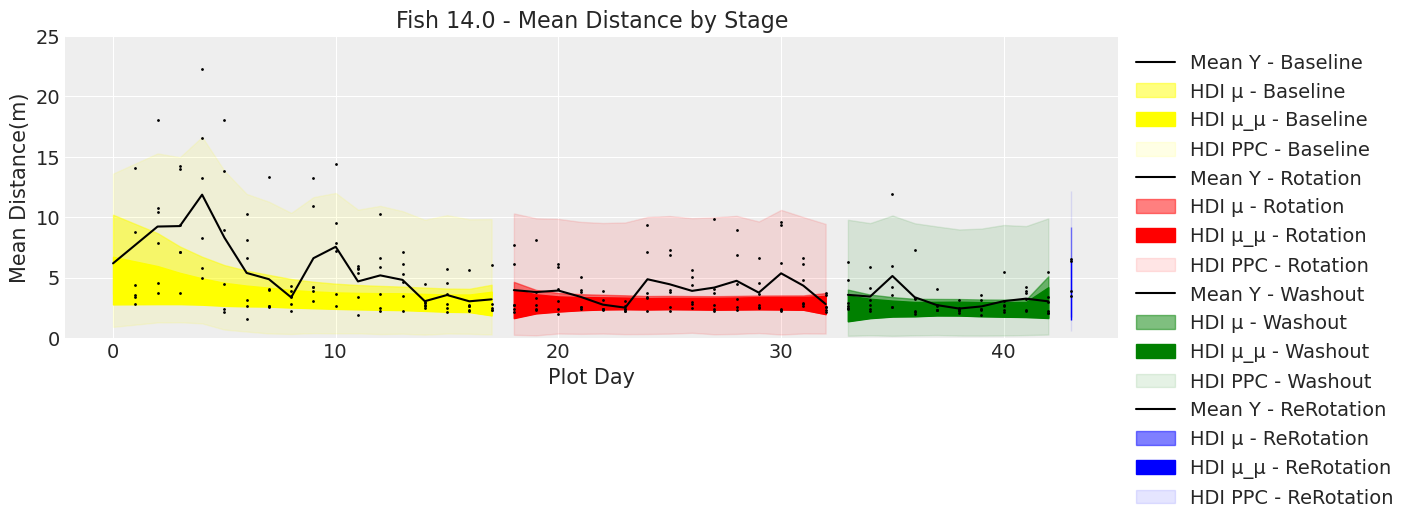

In [223]:
# Iterate over each unique combination of fish and stage to create plots
for fish in ppcplot_df_day['fish'].unique():
    plt.figure(figsize=(14, 4.8))  # Set figure size
    
    for i, stage in enumerate(stages):
# Filter data for the current fish and stage
        data_filter = ppcplot_df_day[(ppcplot_df_day['fish'] == fish) & (ppcplot_df_day['stage'] == stage)]
        data_filter2 = y_obd_plot[(y_obd_plot['fish'] == fish) & (y_obd_plot['stage'] == stage)]
        # Plot mean_y against plotday for the current stage
       # plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
        plt.plot(data_filter['plotday'], data_filter['mean_y'], label=f'Mean Y - {stage}', color='black')
                 # Plot mean_y against plotday for the current stage
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'] ,label=f'mean_μ_μ_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.5,)
        # plt.plot(data_filter['plotday'], data_filter['mean_μ_μ_hdi_97'] ,label=f'mean_μ_μ_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.5,)
        μ_hdi_3_gamma_medians
        plt.fill_between(data_filter['plotday'], data_filter['μ_hdi_3_gamma_means'], data_filter['μ_hdi_97_gamma_means'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
        #plt.fill_between(data_filter['plotday'], data_filter['mean_μ_hdi_3'], data_filter['mean_μ_hdi_97'],color=phase_colors[stage], alpha=0.5, label=f'HDI μ - {stage}')
         # Plot HDI (mean_μ_μ_hdi_3% to mean_μ_μ_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['mean_μ_μ_hdi_3'], data_filter['mean_μ_μ_hdi_97'],color=phase_colors[stage], alpha=1, label=f'HDI μ_μ - {stage}')
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_3'] ,label=f'mean_ppc_hdi_3 - {stage}', color=phase_colors[stage], alpha=0.3,)
        # plt.plot(data_filter['plotday'], data_filter['mean_ppc_hdi_97'] ,label=f'mean_ppc_hdi_97 - {stage}', color=phase_colors[stage], alpha=0.3,)    

            # Plot PPC HDI (mean_ppc_hdi_3% to mean_ppc_hdi_97%) as shaded region
        plt.fill_between(data_filter['plotday'], data_filter['mean_ppc_hdi_3'], data_filter['mean_ppc_hdi_97'],
                            color=phase_colors[stage], alpha=0.1, label=f'HDI PPC - {stage}')
        plt.scatter(data_filter2['plotday'],data_filter2['y'],color= 'black',s =1)
    
    plt.xlabel('Plot Day')  # Set x-axis label
    plt.ylabel('Mean Distance(m)')   # Set y-axis label
    plt.title(f'Fish {fish} - Mean Distance by Stage')  # Set plot title
    plt.legend( bbox_to_anchor=(1, 1))
       # Set fixed data ranges for both axes
    plt.ylim((0,25))
    plt.grid(True)  # Show grid
    plt.show()  # Display the plot


c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\violinplot.py:65: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)


array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>]], dtype=object)

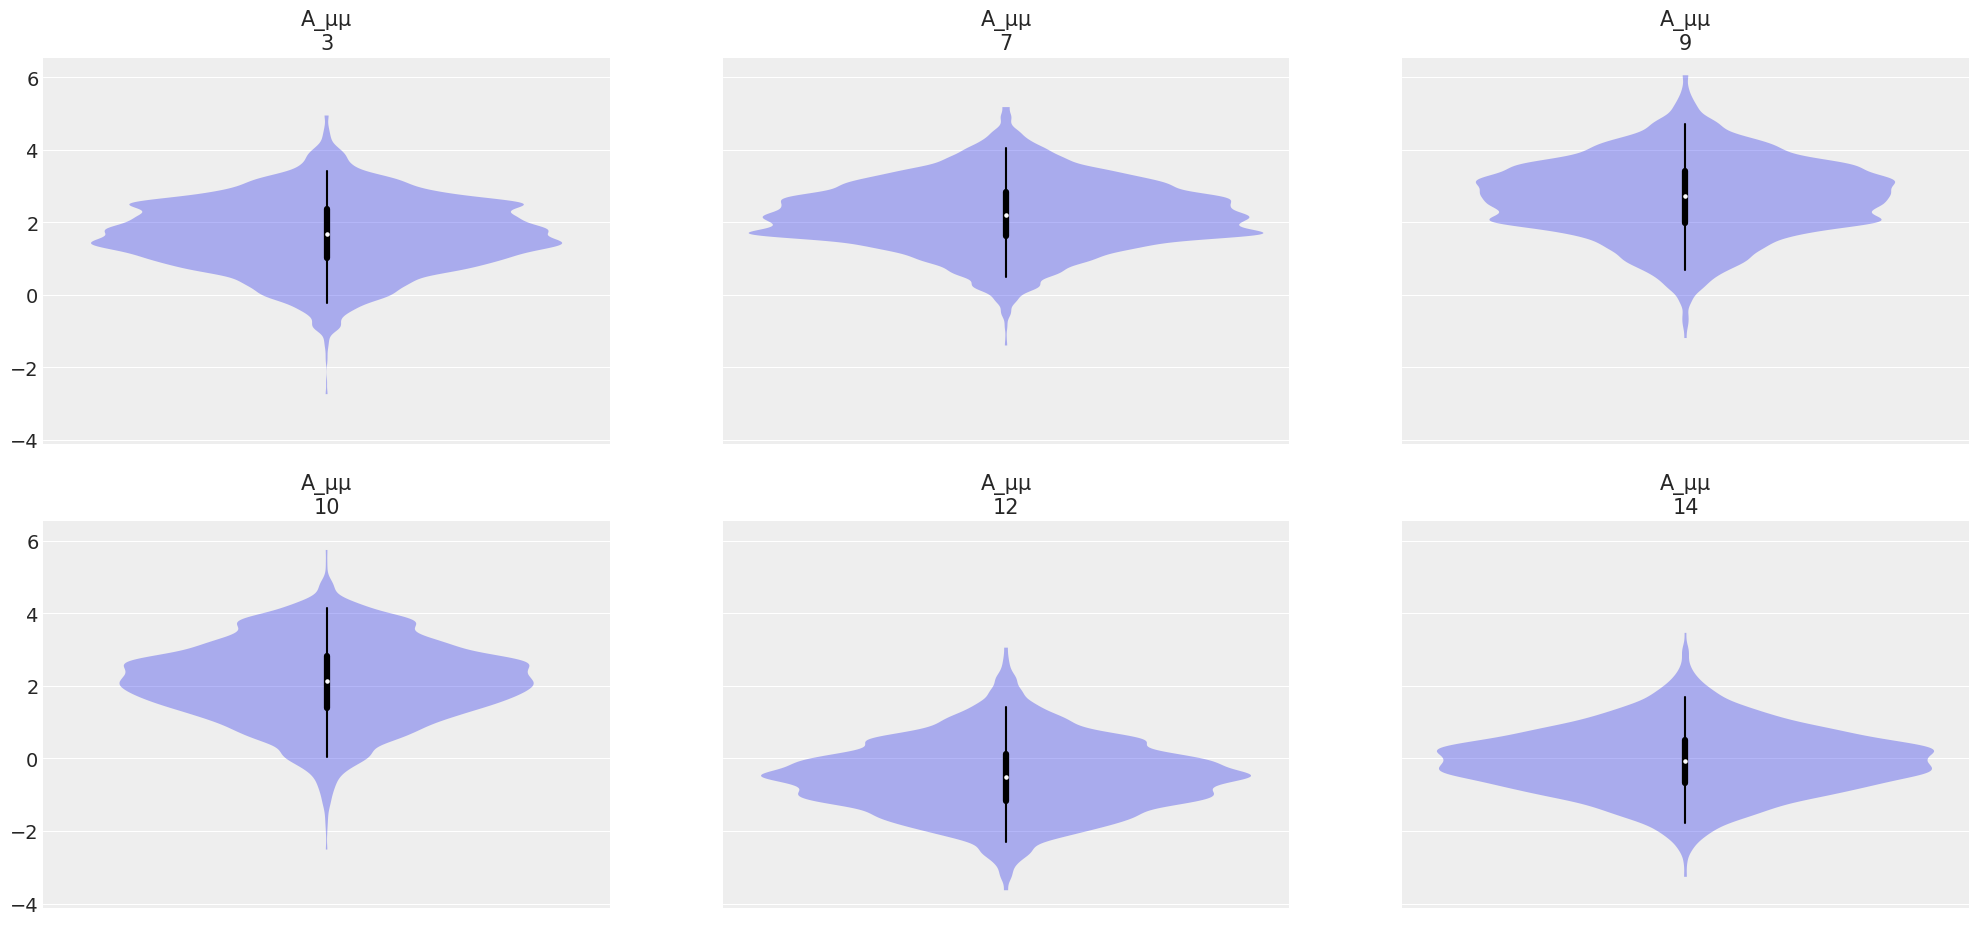

In [224]:

# Specify the variable names (parameters) you want to plot
var_names = ['A_μμ']  # Example: Replace with your desired variable names
dfr = posterior.sel({'stages':'Rotation' })
# Plot violin plot for selected variables
az.plot_violin(data=dfr, var_names=var_names)



array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>]], dtype=object)

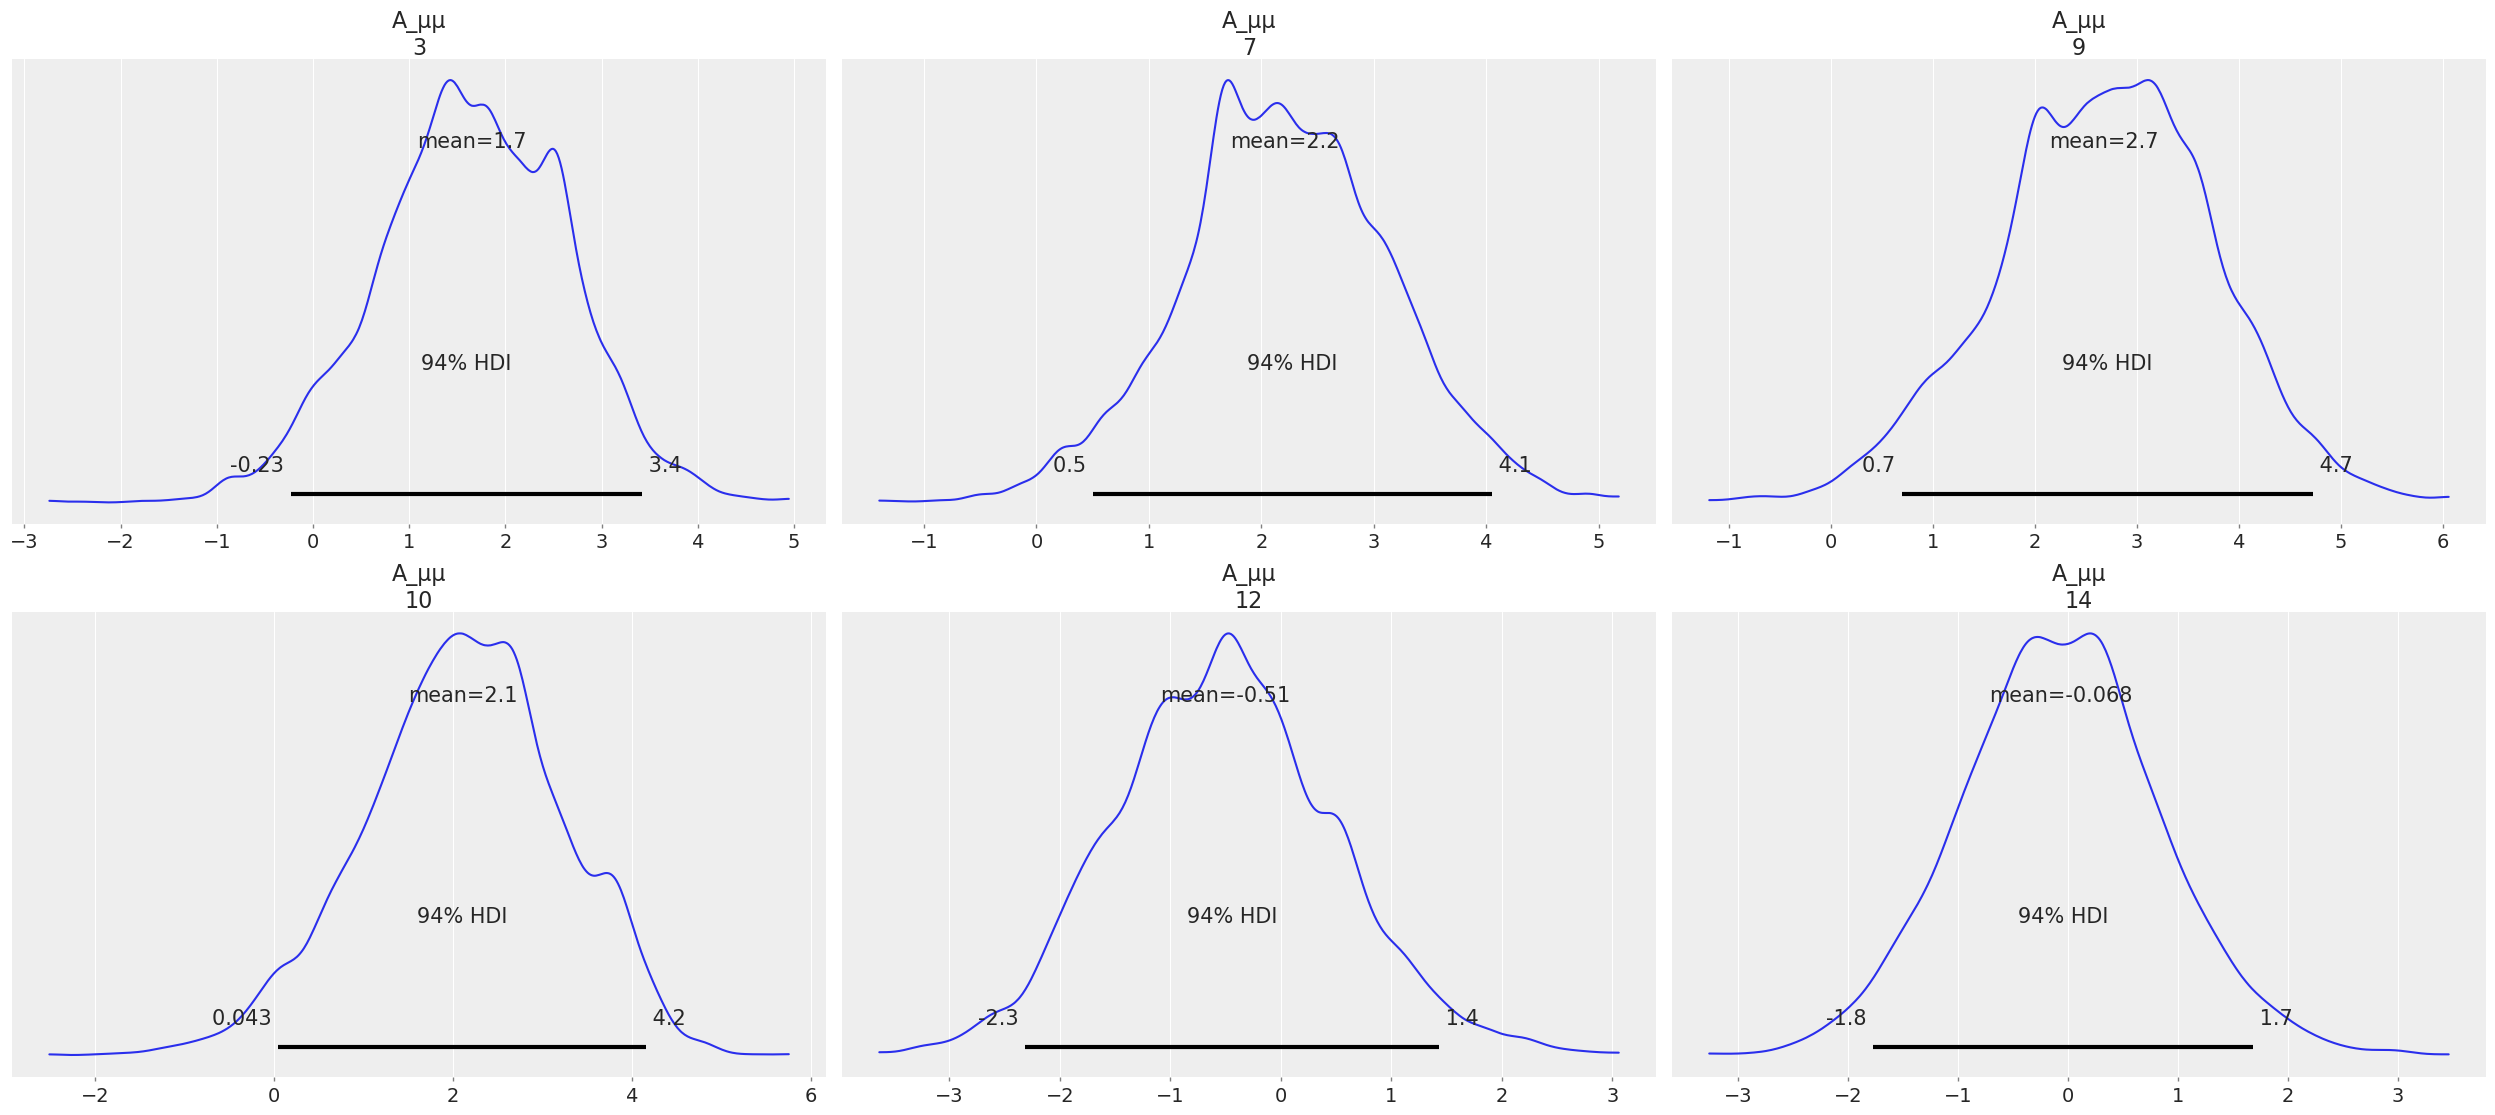

In [225]:
az.plot_posterior(posterior, var_names=['A_μμ'], coords={'stages': 'Rotation'})

array([[<Axes: title={'center': 'A_μμ\n3'}>,
        <Axes: title={'center': 'A_μμ\n7'}>,
        <Axes: title={'center': 'A_μμ\n9'}>],
       [<Axes: title={'center': 'A_μμ\n10'}>,
        <Axes: title={'center': 'A_μμ\n12'}>,
        <Axes: title={'center': 'A_μμ\n14'}>]], dtype=object)

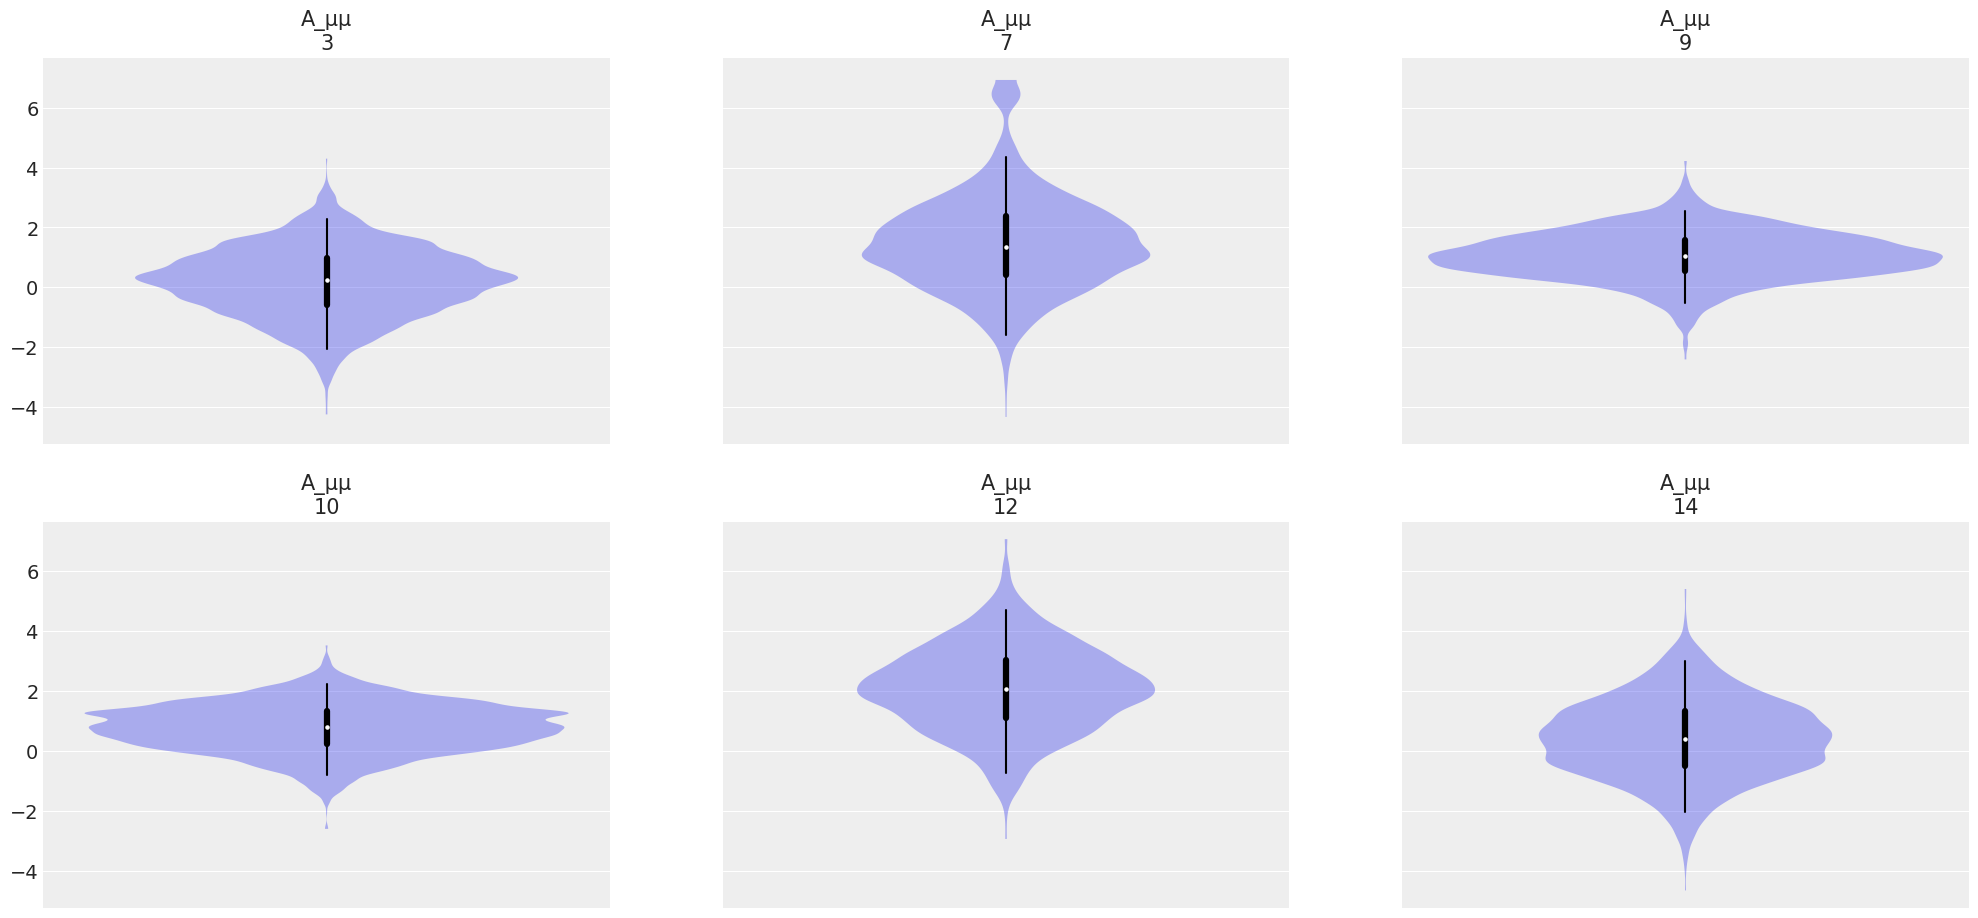

In [226]:

# Specify the variable names (parameters) you want to plot
var_names = ['A_μμ']  # Example: Replace with your desired variable names
dfrr = posterior.sel({'stages':'ReRotation' })
# Plot violin plot for selected variables
az.plot_violin(data=dfrr, var_names=var_names)



In [227]:
μ_A_μμ_across = dfrr.A_μμ.mean(dim='fish')

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'μ_Aμμ across fish')

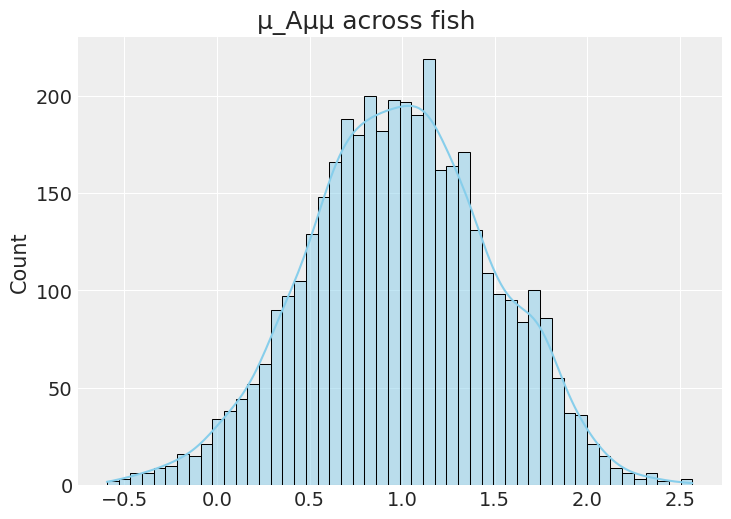

In [228]:
# Flatten the data array to a 1-dimensional numpy array
μ_Aμμ_Rdata = μ_A_μμ_across.values.flatten()
sns.histplot(μ_Aμμ_Rdata, bins=50, kde=True, color='skyblue')
plt.suptitle('μ_Aμμ across fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\arviz\plots\backends\matplotlib\violinplot.py:65: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0)


(-100.0, 100.0)

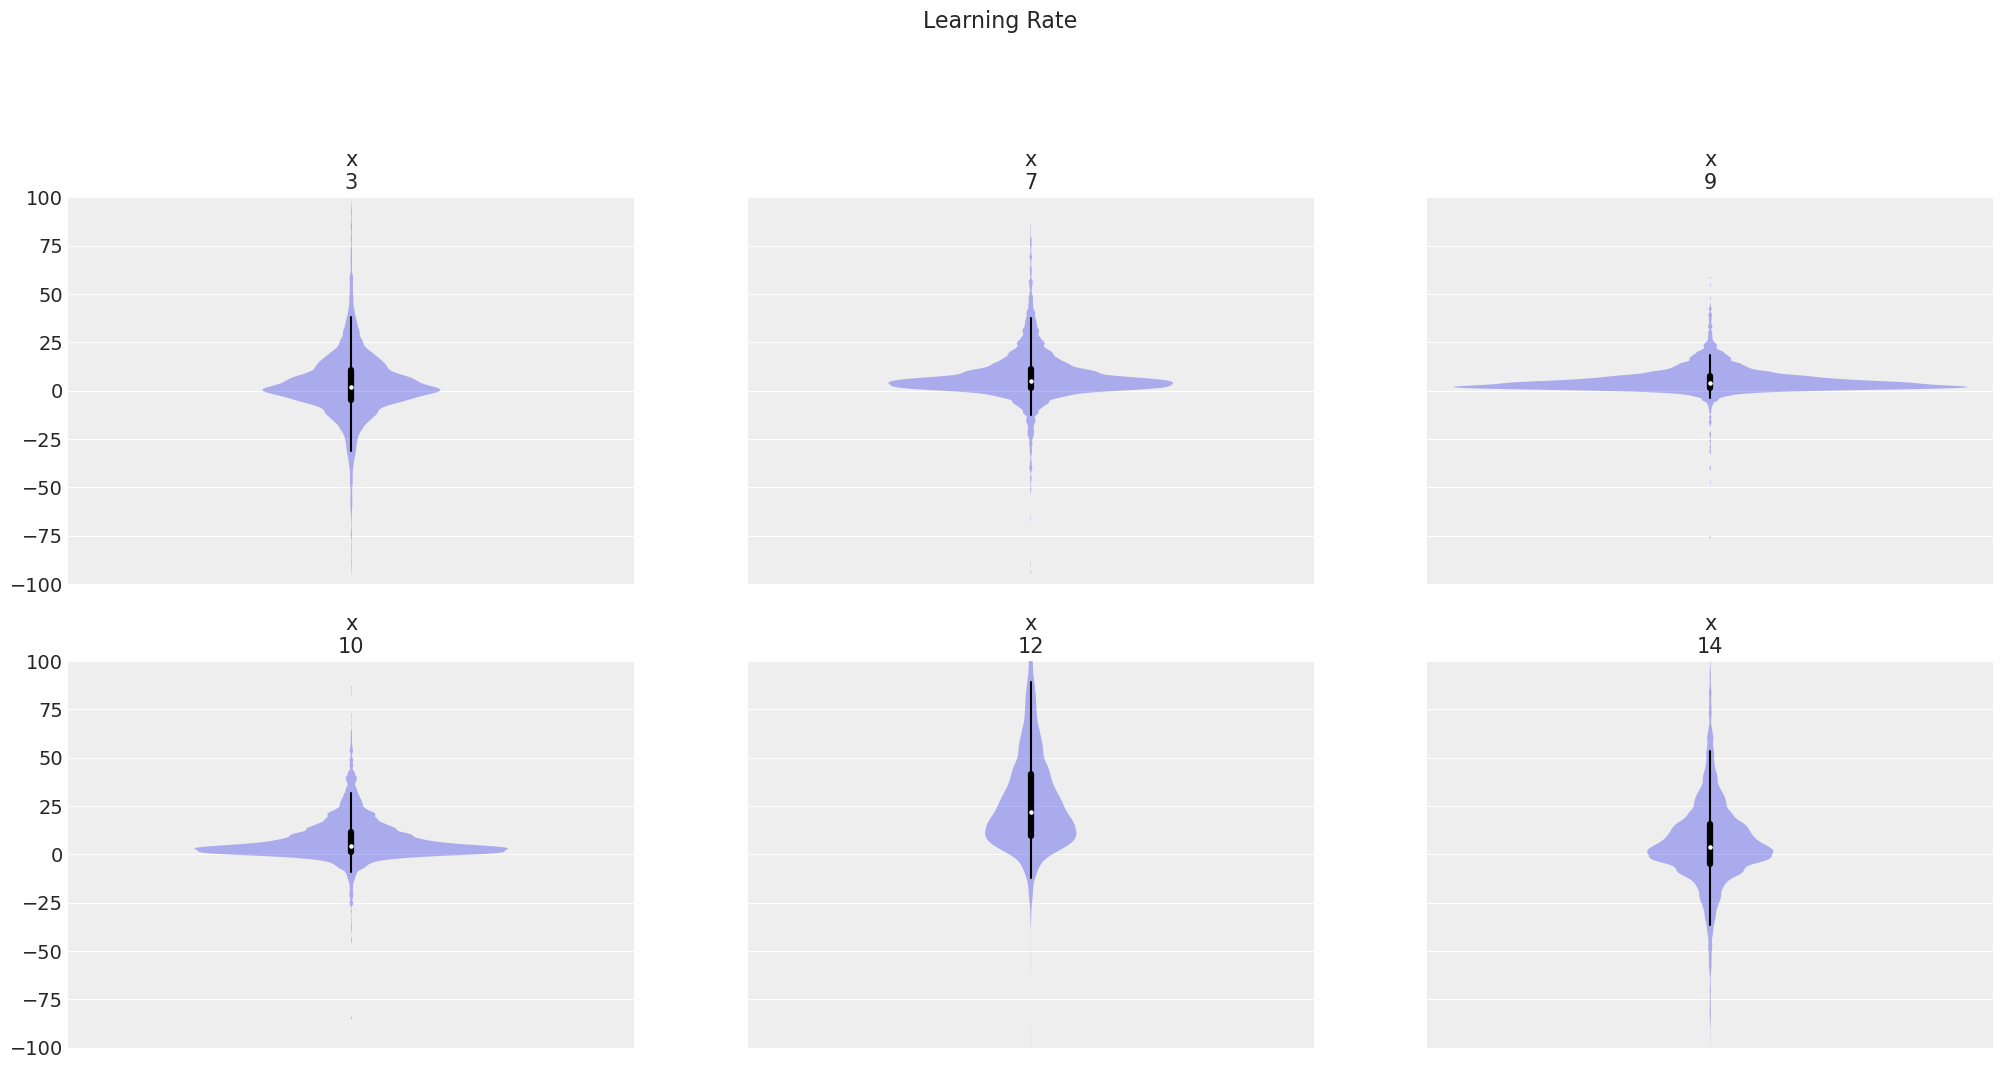

In [229]:
LR = posterior.A_μμ * posterior.τ_μ

dfrr = LR.sel({'stages':'ReRotation' })
# Plot violin plot for selected variables
az.plot_violin(data=dfrr)
# Set a larger title for the plot
# Set a larger title above the plot

plt.suptitle('Learning Rate', fontsize=16, y=1.05)  # Adjust fontsize and y position as needed
plt.ylim((-100,100))


In [230]:
#az.plot_trace(posterior, var_names=['μ_Aμμ '], coords={'stages': 'Rotation'});

Text(0.5, 1.05, 'Learning Rate')

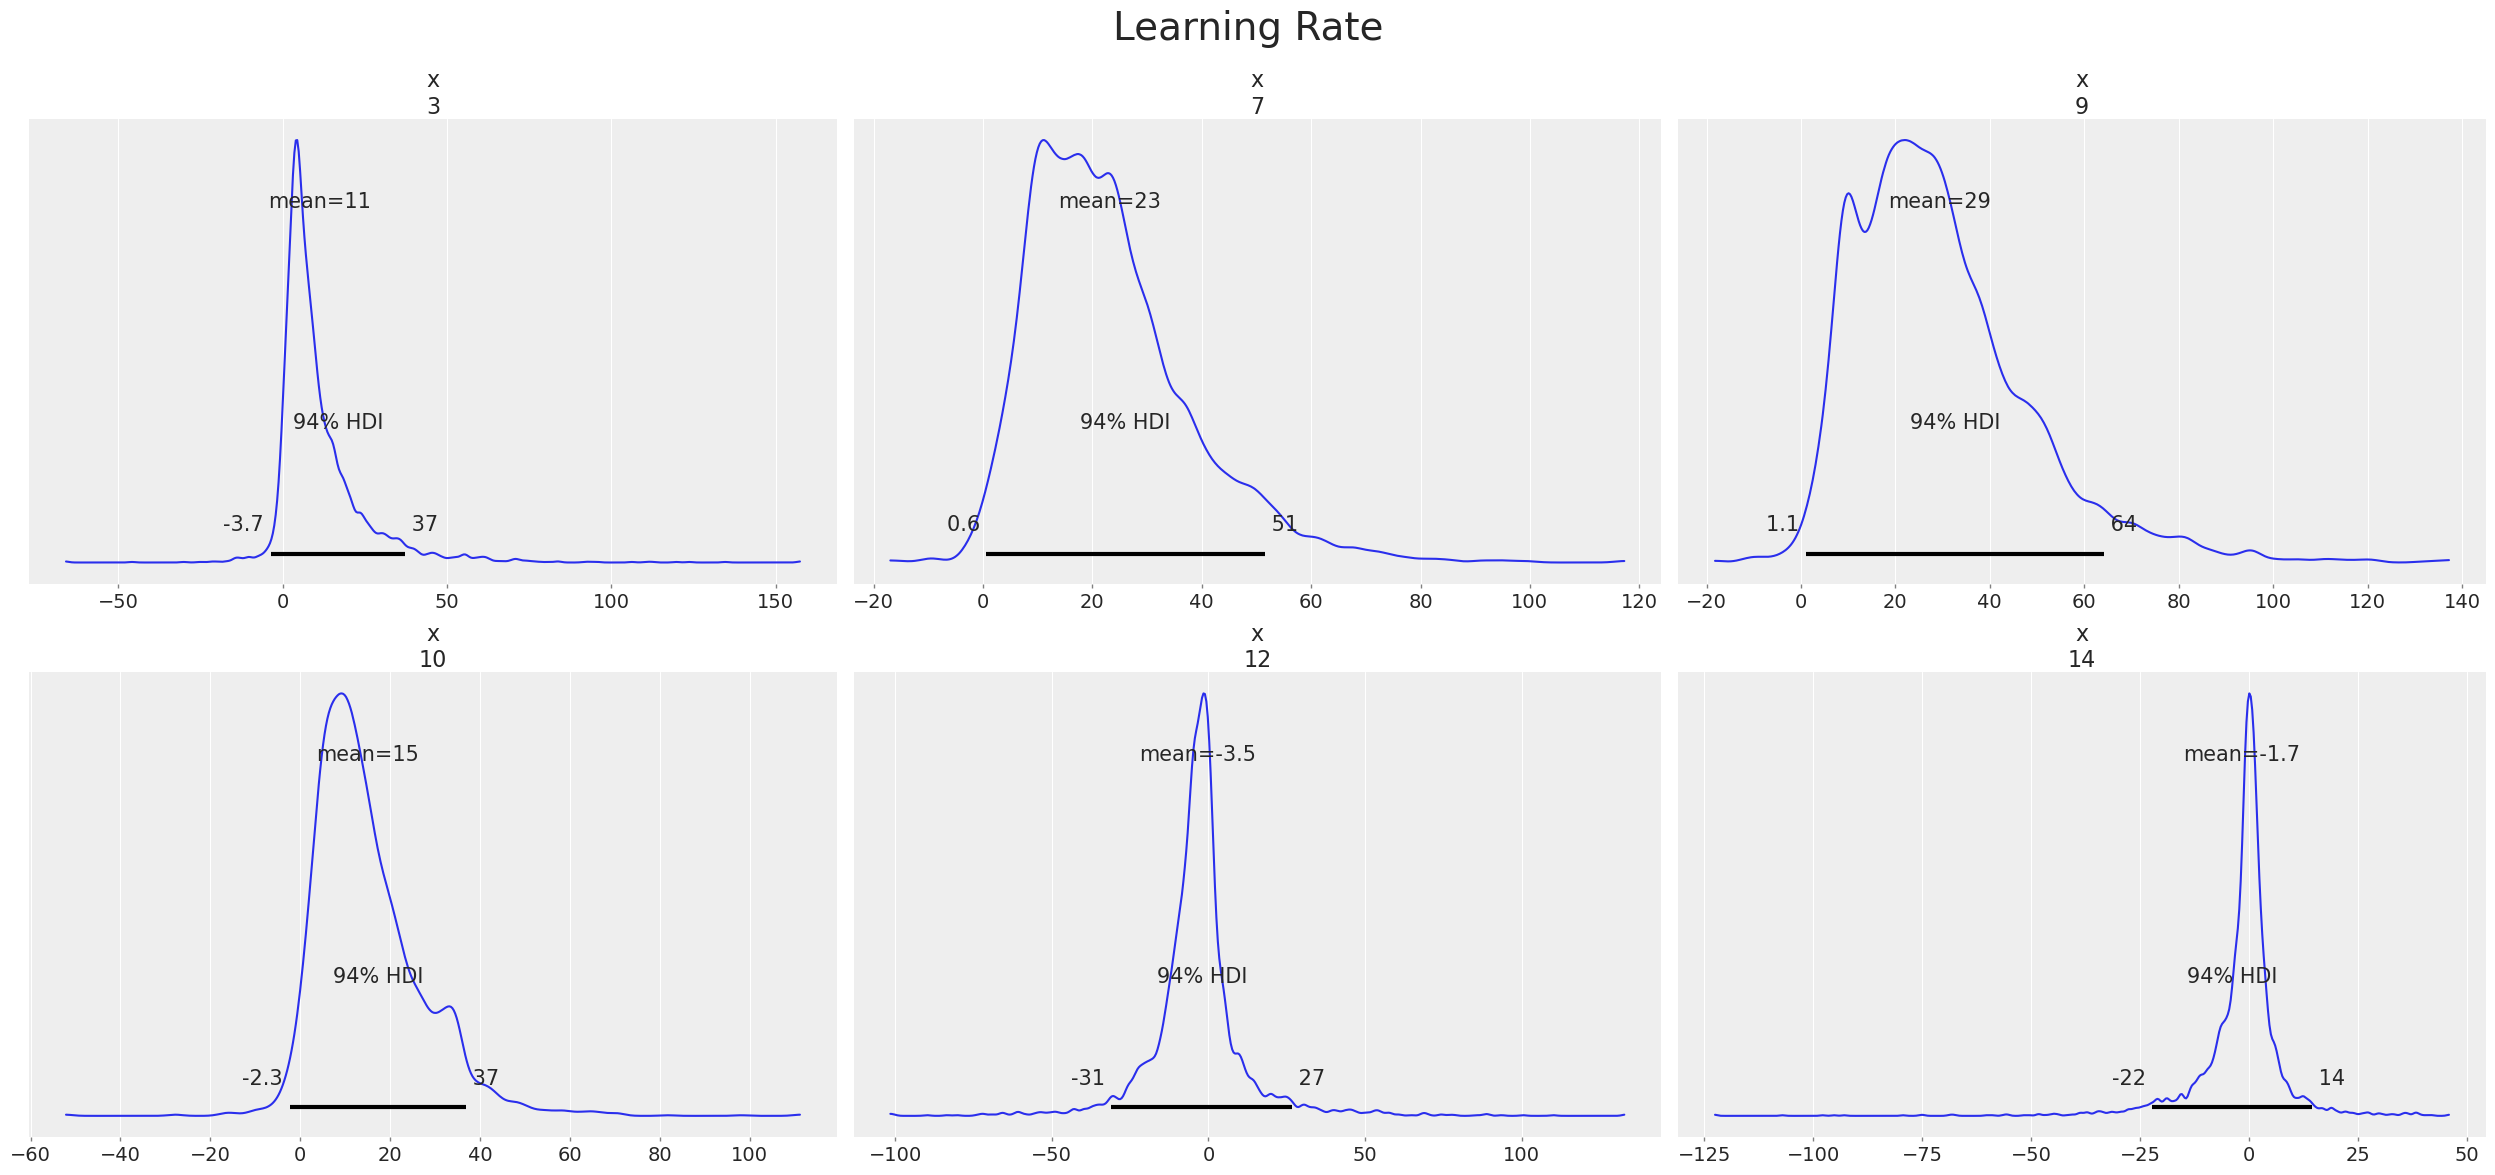

In [231]:

#az.plot_trace(LR, coords={'stages': 'Rotation'});
az.plot_posterior(LR, coords={'stages': 'Rotation'})
# Set a larger title above the plot
plt.suptitle('Learning Rate', fontsize=28, y=1.05)  # Adjust fontsize and y position as needed


In [232]:
LR_R = LR.sel({'stages':'Rotation' })

c:\Users\86153\anaconda3\envs\pymc_env\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.05, 'Learning rates across fish')

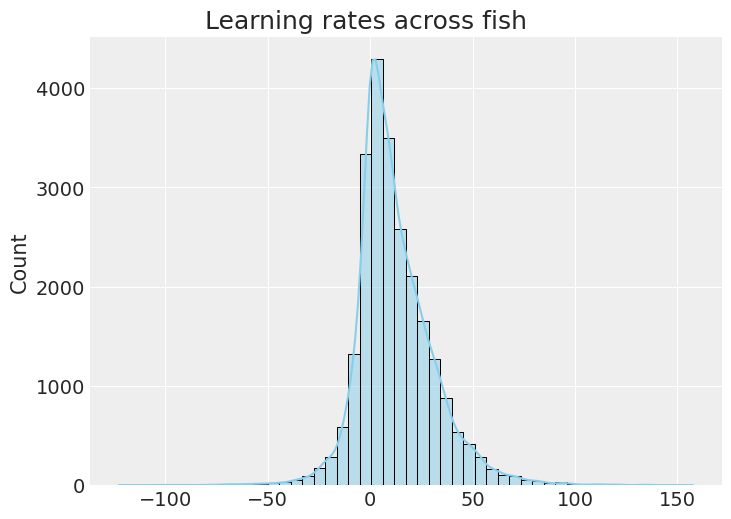

In [233]:
# Flatten the data array to a 1-dimensional numpy array
flattened_data = LR_R.values.flatten()
sns.histplot(flattened_data, bins=50, kde=True, color='skyblue')
plt.suptitle('Learning rates across fish', fontsize=18, y=1.05)  # Adjust fontsize and y position as needed

In [234]:
posterior

<xarray.Dataset> Size: 254MB
Dimensions:  (chain: 4, draw: 1000, fish: 6, stages: 5, data: 1949)
Coordinates:
  * chain    (chain) int32 16B 0 1 2 3
  * draw     (draw) int32 4kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999
  * fish     (fish) int32 24B 3 7 9 10 12 14
  * stages   (stages) <U10 200B 'Baseline' 'Rotation' ... 'Washout 2'
  * data     (data) int32 8kB 0 1 2 3 4 5 6 ... 1943 1944 1945 1946 1947 1948
Data variables:
    A_μμ     (chain, draw, fish, stages) float64 960kB 2.483 1.537 ... 1.367
    A_σμ     (chain, draw, fish, stages) float64 960kB 1.236 1.592 ... 1.141
    μ        (chain, draw, data) float64 62MB 4.189 8.633 5.998 ... 6.632 3.957
    μ_μ      (chain, draw, data) float64 62MB 5.535 5.535 5.535 ... 4.099 4.099
    μ_μ_inf  (chain, draw, fish, stages) float64 960kB 3.052 4.208 ... 6.605
    σ        (chain, draw, data) float64 62MB 3.857 3.232 1.235 ... 4.483 3.829
    σ_μ      (chain, draw, data) float64 62MB 1.923 1.923 1.923 ... 2.79 2.79
    σ_μ_inf  (chain, draw, fish, stages) float64 960kB 0.6871 0.5528 ... 2.169
    τ_μ      (chain, draw, fish, stages) float64 960kB 18.93 3.938 ... 18.58
Attributes:
    created_at:                 2024-05-21T06:32:03.235798+00:00
    arviz_version:              0.18.0
    inference_library:          pymc
    inference_library_version:  5.12.0
    sampling_time:              487.79220175743103
    tuning_steps:               1000